<a href="https://colab.research.google.com/github/rwikdutta/handson_repo/blob/master/HandsOn_ML_Session_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports and other helper functions

In [1]:
!pip install flask-ngrok #This is how you can install libraries that are not present.
# Note the ! at the beginning of this command, which specifies that it is a terminal command and not a python line of code

In [2]:
import sys
import sklearn
import numpy as np
import os,sys
import seaborn as sns
import time
import pandas as pd
from joblib import dump, load
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from pathlib import Path
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from flask_ngrok import run_with_ngrok
from flask import Flask
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.figure(figsize=(20,8))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

In [3]:
!git clone https://github.com/rwikdutta/handson_repo.git
#!mv handson_repo/* .

Cloning into 'handson_repo'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 93 (delta 26), reused 81 (delta 14), pack-reused 0
Unpacking objects: 100% (93/93), done.


In [4]:
#Helper Function
def plot_dataset(X, y, axes):
    #plt.figure(figsize=(20,8))
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "rs",markersize=2)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "b^",markersize=2)
    plt.axis(axes)
    #plt.legend()
    plt.grid(True, which='both')
    plt.xlabel(r"$x_0$", fontsize=20)
    plt.ylabel(r"$x_1$", fontsize=20, rotation=0)

In [5]:
#Helper Function
def plot_predictions(clf, axes):
    #plt.figure(figsize=(20,8))
    x0s = np.linspace(axes[0], axes[1], 1000)
    x1s = np.linspace(axes[2], axes[3], 1000)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

In [6]:
#Helper Function
def run_hyper_params_grid_search(hyperparams_dict,estimator_type,constant_estimator_params,model_file_path_prepend,train_model):
  """
  Runs grid search over the given settings of parameters in hyperparams_dict and returns the result.
  """
  performance_data=[]
  for each_param_grid in ParameterGrid(hyperparams_dict):
    #print(list(each_param_grid))
    save_model_path='{}'.format(model_file_path_prepend)
    for k,v in each_param_grid.items():
      save_model_path+="_{}_{}".format(k,v)
    save_model_path+='.pkl'
    if train_model=='True' or (train_model=='If Not Exists' and not Path(save_model_path).exists()):
      curr_model=estimator_type(**each_param_grid,**constant_estimator_params)
      start=time.time()
      curr_model.fit(data_train_X,data_train_y)
      end=time.time()
      print("Training model {} took {} secs".format(save_model_path,end-start))
      dump(curr_model,save_model_path)
    else:
      assert Path("{}".format(save_model_path)).exists(),"Hey, you don't have the model file already saved...so looks like you will have to change\
        train_model to True to retrain the model or load the model file ( {} )".format(save_model_path)
      curr_model=load(save_model_path)
    yhat_val=curr_model.predict(data_val_X)
    each_param_grid['precision']=precision_score(yhat_val,data_val_y)
    each_param_grid['recall']=recall_score(yhat_val,data_val_y)
    each_param_grid['f1_score']=f1_score(yhat_val,data_val_y)
    each_param_grid['model_path']=save_model_path
    print(each_param_grid)
    performance_data.append(each_param_grid)
    del curr_model
  return pd.DataFrame(performance_data)

# 0. Objectives, Pre-requisites and Target Audience

## Objectives

- Explain the core concepts of ML through examples
- Show how to work with a real world dataset
-  ( Hopefully ) Motivate few people to learn more about ML

## Pre-requisites

- Introductory knowledge of Python is helpful ( but not mandatory )

## Target Audience

- People inquisitive about Machine Learning
- People who wants to dive into the world of Machine Learning but don't know where to start
- Anyone else who's interested

# 1. Introduction to ML


- What is Machine Learning?
> Machine learning is an application of artificial intelligence (AI) that provides systems the ability to automatically learn and improve from experience without being explicitly programmed.
In simple terms, when $y=f(x)$, $x$ and $y$ being already given, Machine Learning allows the system to learn *f(x)*. ( Note: This doesn't exactly hold true for unsupervised learning, but we can gloss over it for now to simplify things. )
- What is Deep Learning?
> Deep Learning is a subset of Machine Learning where the models are much bigger ( deeper ) and contains multiple layers. Most of the state of the art results in recent years has come from Deep Learning, specially when it comes to non-tabular data.
- What is artificial Intelligence?
> Artificial intelligence (AI) refers to the simulation of human intelligence in machines that are programmed to think like humans and mimic their actions.

![ML Diagram](https://blogvaronis2.wpengine.com/wp-content/uploads/2019/09/cybersecurity-machine-learning-differences.gif)
- What is data analytics?
> Exploration of data to get meaningful insights. Because ultimately data is only as useful as the amount of useful information that you can get out of them.
- Why is it relevant today?
> ![Data Explosion](https://resources.vzaar.com/vzaar/vz4/4e2/target/vz44e2bbce33634606a340e689ea846e87.jpg)

# 2. Dive in 1: Training a Simple Logistic Regression Model

## 1. Creating a synthetic dataset for understanding linear classification

This dataset will have 2 input features: X0 and X1 and give an output Y where Y can be either 0 or 1.

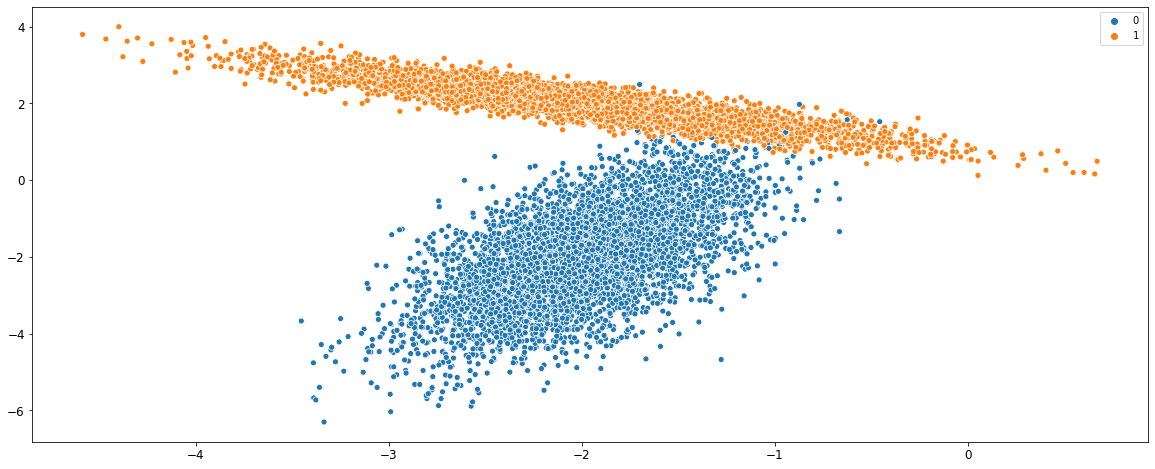

In [7]:
from sklearn.datasets import make_classification
# Generate Clean data
X,y = make_classification(n_samples=10000, n_features=2, n_informative=2,n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1,class_sep=2,flip_y=0,weights=[0.5,0.5], random_state=17)
#f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(20,8))
plt.figure(figsize=(20,8))
sns.scatterplot(X[:,0],X[:,1],hue=y);
plt.show()

In [8]:
X.shape,y.shape

((10000, 2), (10000,))

## 2. Using Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
log_clf=Pipeline([
        ("scaler", StandardScaler()),
        ("log_reg", LogisticRegression(random_state=42)),
    ])
log_clf.fit(X,y)
log_clf['log_reg'].coef_,log_clf['log_reg'].intercept_

(array([[ 1.33825445, 12.16035688]]), array([-5.52088304]))

In [11]:
log_clf

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

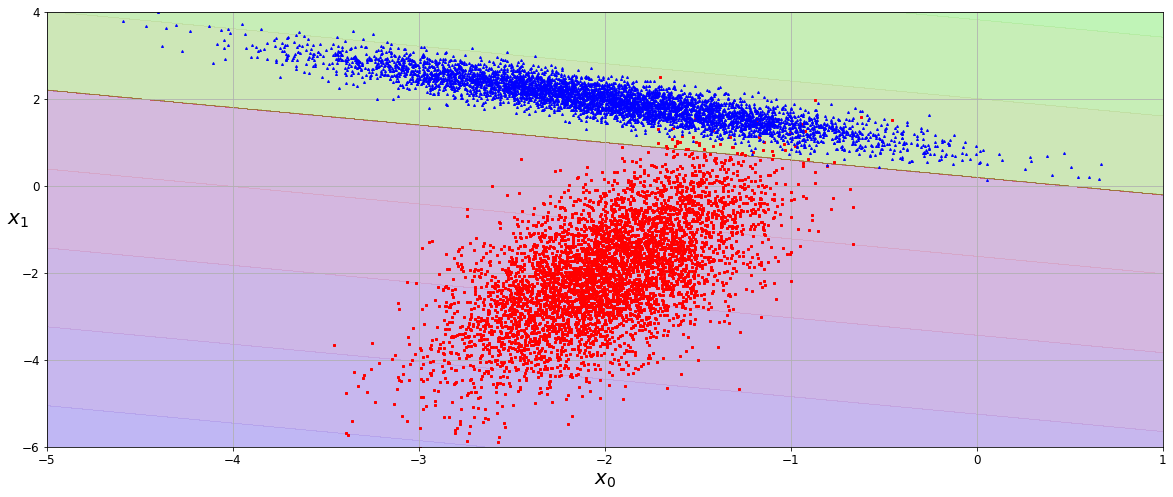

In [12]:
plt.figure(figsize=(20,8))
plot_predictions(log_clf,[-5,1,-6,4])
plot_dataset(X,y,[-5,1,-6,4])
plt.show()

In [13]:
log_clf.score(X,y)

0.9945

In [14]:
# Predicting using log_clf_1
inp_X0 =   -4.33#@param {type: "number"}
inp_X1 =    2.97#@param {type: "number"}
out=log_clf.predict([[inp_X0,inp_X1]])
print("Output=Class {}".format(out[0]))

Output=Class 1


![Scikit Learn Estimator API](https://static.packt-cdn.com/products/9781789800265/graphics/d49a2e95-8f22-42ed-89f1-474b3d028787.png)

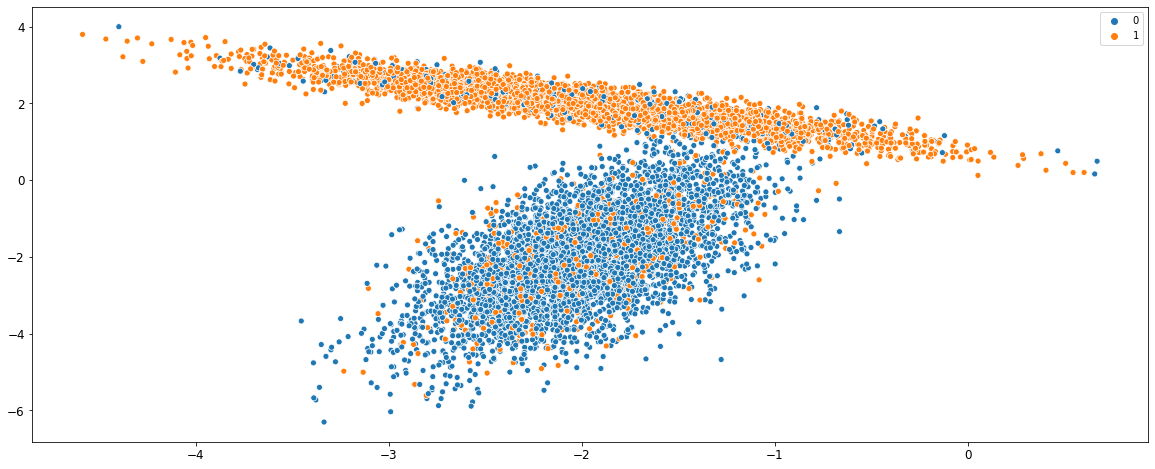

In [15]:
X_noisy,y_noisy = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1,class_sep=2,flip_y=0.2,weights=[0.5,0.5], random_state=17)
plt.figure(figsize=(20,8))
sns.scatterplot(X_noisy[:,0],X_noisy[:,1],hue=y_noisy);
plt.show()

In [16]:
X_noisy.shape,y_noisy.shape

((10000, 2), (10000,))

In [17]:
log_clf_2=Pipeline([
        ("scaler", StandardScaler()),
        ("log_reg", LogisticRegression(random_state=42)),
    ])
log_clf_2.fit(X_noisy,y_noisy)
log_clf_2['log_reg'].coef_,log_clf_2['log_reg'].intercept_

(array([[0.09374046, 2.17455789]]), array([-0.18274007]))

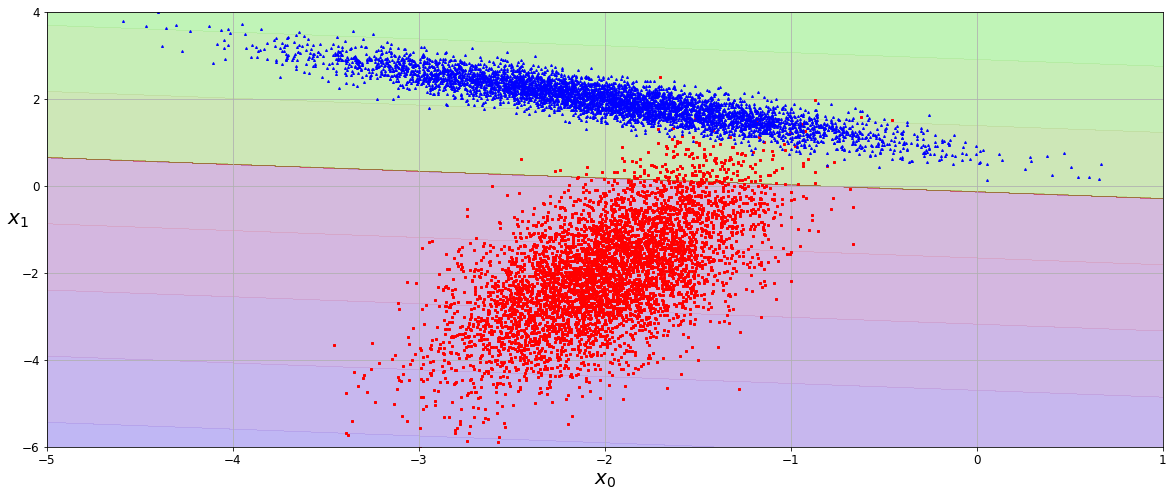

In [18]:
plt.figure(figsize=(20,8))
plot_predictions(log_clf_2,[-5,1,-6,4])
plot_dataset(X,y,[-5,1,-6,4])
plt.show()

In [19]:
log_clf_2.score(X_noisy,y_noisy)

0.8783

In [20]:
inp_X0 =   0#@param {type: "number"}
inp_X1 =    0.5#@param {type: "number"}
out=log_clf.predict([[inp_X0,inp_X1]])
print("Output=Class {}".format(out[0]))

Output=Class 1


## 3. How Logistic Regression works?



During training:

- Inputs: $x=[x_0,x_1]$
- How predictions are calculated: $\hat{y}=mx+c$ ( m and c are determined by the model during training, they are called weights. )
- Truth Output: $y$
- $loss=lossFunction(\hat{y},y)$ ( loss is used as an indicator of how good or bad the model is performing on the given examples )
- Update the weights ( $m$ and $c$ ) so that the loss function is optimized.
- At the end of the training, we get weights ( $m$ and $c$ ) which are hopefully optimized for the dataset that we wanted to train on.

During inference:
- Inputs: $x=[x_0,x_1]$
- How predictions are calculated: $\hat{y}=mx+c$ ( $m$ and $c$ determined by the model during training )
- Final Output: $\hat{y}$


![Logistic Regression in Action](https://miro.medium.com/max/700/1*PkEl-8DBQa-xEft_tacXLQ.gif)

# Dive in 2: Training an SVM model ( Introducting Non-Linearity )

## 1. Creating a dataset

In [21]:
from sklearn.datasets import make_moons

In [22]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.15, random_state=42)
X_moons.shape,y_moons.shape

((1000, 2), (1000,))

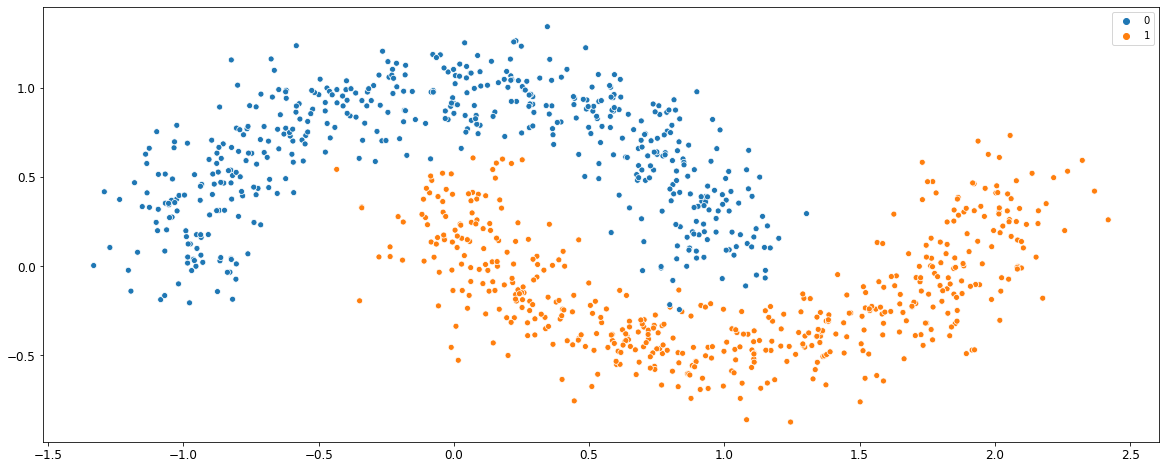

In [23]:
plt.figure(figsize=(20,8))
sns.scatterplot(X_moons[:,0],X_moons[:,1],hue=y_moons);
plt.show()

## Trying out a Logistic Regression Model

In [24]:
log_clf_moons=Pipeline([
        ("scaler", StandardScaler()),
        ("log_reg", LogisticRegression(random_state=42)),
    ])
log_clf_moons.fit(X_moons,y_moons)
log_clf_moons['log_reg'].coef_,log_clf_moons['log_reg'].intercept_

(array([[ 1.08282777, -2.64658626]]), array([-0.03269433]))

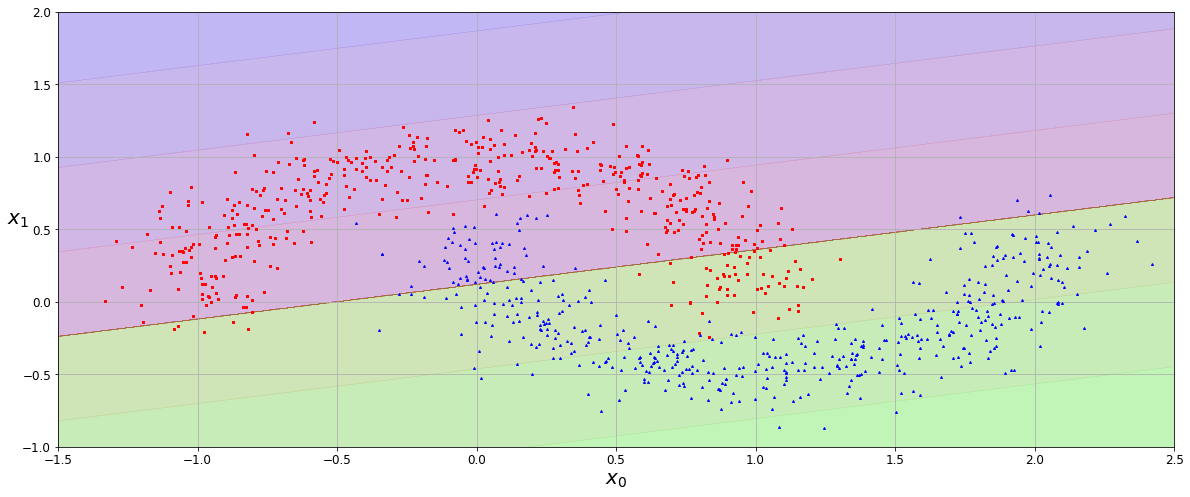

In [25]:
plt.figure(figsize=(20,8))
plot_predictions(log_clf_moons,[-1.5,2.5,-1,2])
plot_dataset(X_moons,y_moons,[-1.5,2.5,-1,2])
plt.show()

In [26]:
log_clf_moons.score(X_moons,y_moons)

0.872

## Normalizing Your Data
- For certain types of models ( Logistic Regression, SVM etc. ), the data needs to be normalized ( i.e. adjusted so that it has a mean of 0 and std. deviation of 1 ).
- If we don't normalize it, the model performance takes a hit. We will be using ``StandardScaler()`` to normalize our data wherever necessary.

## Trying a non linear ( SVM ) Model

In [27]:
from sklearn.svm import SVC

In [28]:
svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(random_state=42)),
    ])
svm_clf.fit(X_moons,y_moons)
svm_clf

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=42, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [29]:
svm_clf.score(X_moons,y_moons)

0.989

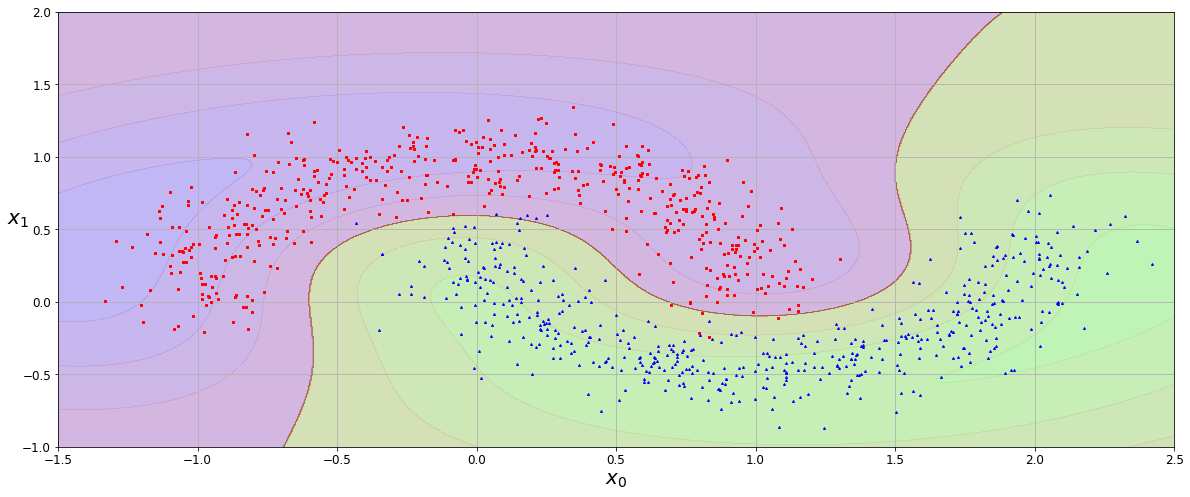

In [30]:
plt.figure(figsize=(20,8))
plot_predictions(svm_clf,[-1.5,2.5,-1,2])
plot_dataset(X_moons,y_moons,[-1.5,2.5,-1,2])
plt.show()

Let's see what happens if we slightly change the configuration. Can we improve the results?

## SVM Much Less Regularized

In [31]:
svm_clf_non_reg = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(C=100000000,random_state=42)),
    ])
svm_clf_non_reg.fit(X_moons,y_moons)
svm_clf_non_reg

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=100000000, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=42, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [32]:
svm_clf_non_reg.score(X_moons,y_moons)

0.998

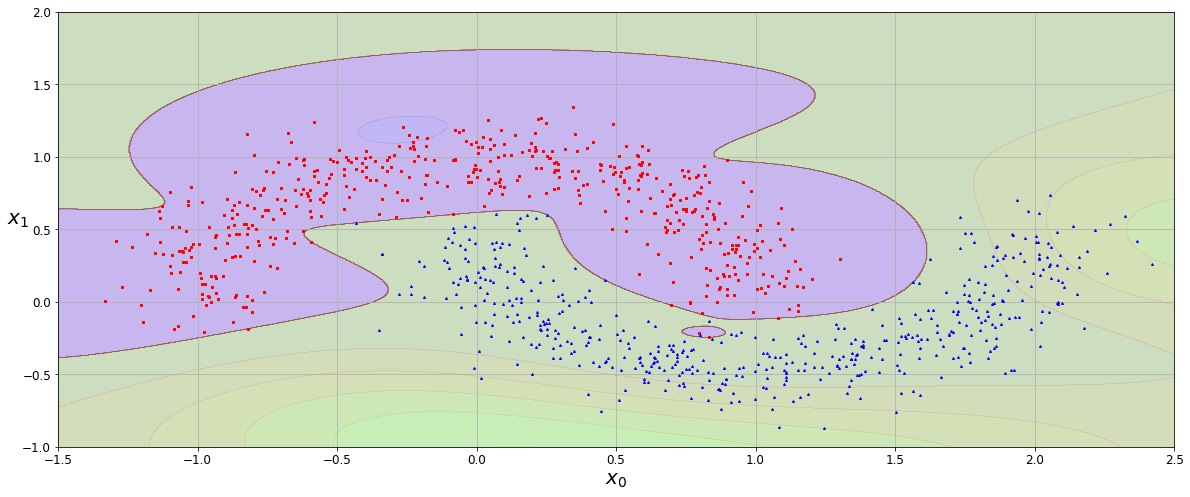

In [33]:
plt.figure(figsize=(20,8))
plot_predictions(svm_clf_non_reg,[-1.5,2.5,-1,2])
plot_dataset(X_moons,y_moons,[-1.5,2.5,-1,2])
plt.show()

Does this look okay?

## Seeing how hyper-parameters affect your model

- What are Hyperparameters?
> Hyper-parameters are certain parameters which controls how the model behaves.
For eg., 
 - Learning Rate: It determines how much the weights can change at once
 - Regularization: It determines how much your model generalizes.

For example, how parameter ``C`` in SVM affects our model?  : https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

```

C (float, default=1.0)
Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive.
The penalty is a squared l2 penalty.
```

## Let's see how well both these models generalize to a slightly different distribution

In [34]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.15, random_state=677)
X_moons_test.shape,y_moons_test.shape

((1000, 2), (1000,))

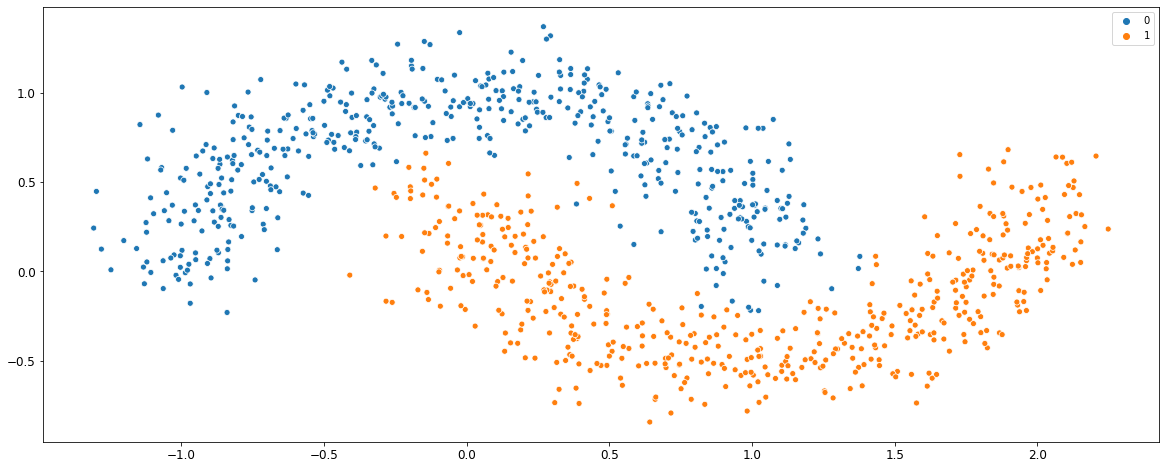

In [35]:
plt.figure(figsize=(20,8))
sns.scatterplot(X_moons_test[:,0],X_moons_test[:,1],hue=y_moons_test);
plt.show()

In [36]:
svm_clf.score(X_moons_test,y_moons_test),svm_clf_non_reg.score(X_moons_test,y_moons_test)

(0.986, 0.983)

- Performance of Test Set on svm_clf: 0.986
- Performance of Test Set on svm_clf_non_reg: 0.983

This is opposite to what we saw during training. It looks like the svm_clf_non_reg model doesn't generalize well.

This is why we need to have a seperate set of data which we use for testing so that we can verify that our model generalizes well.

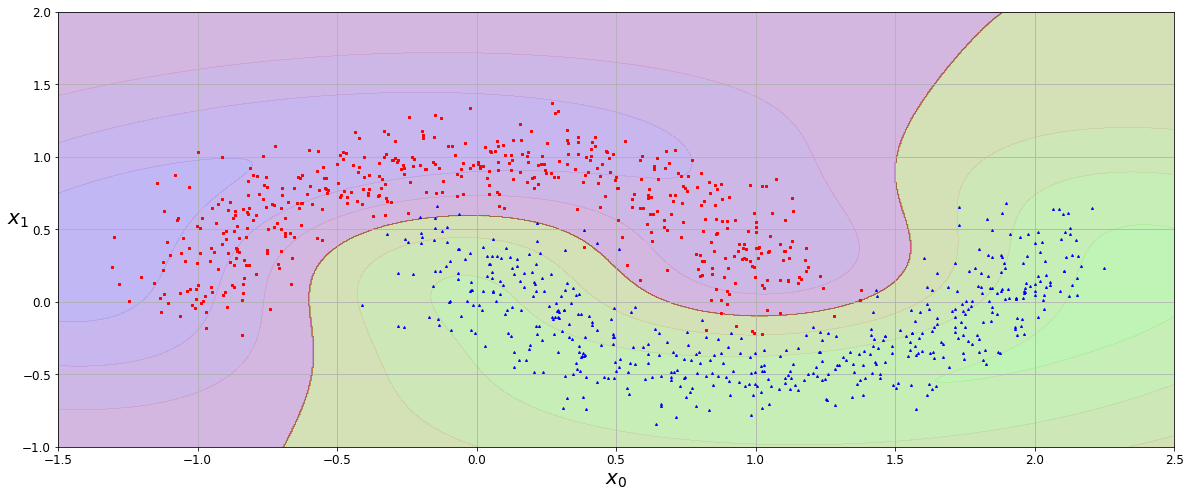

In [37]:
plt.figure(figsize=(20,8))
plot_predictions(svm_clf,[-1.5,2.5,-1,2])
plot_dataset(X_moons_test,y_moons_test,[-1.5,2.5,-1,2])
plt.show()

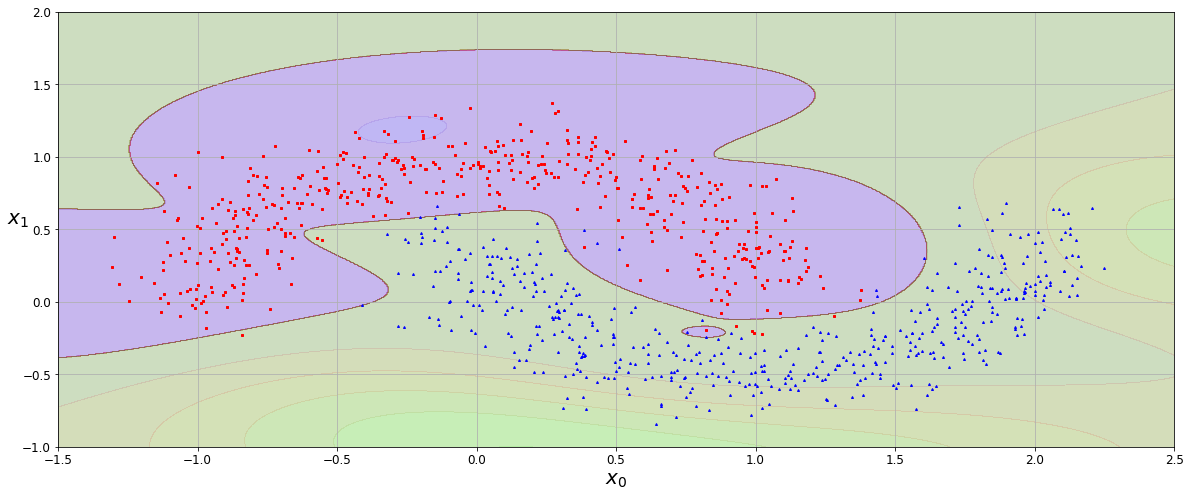

In [38]:
plt.figure(figsize=(20,8))
plot_predictions(svm_clf_non_reg,[-1.5,2.5,-1,2])
plot_dataset(X_moons_test,y_moons_test,[-1.5,2.5,-1,2])
plt.show()

## Bias vs Variance

- **Bias** is the simplifying assumptions made by the model to make the target function easier to approximate.
- **Variance** is the amount that the estimate of the target function will change given different training data.

> A good machine learning model ensures that there isn't too much bias or too much variance in the model. It should be a good fit for the data that it is trained on and at the same time, it should also give good performance during prediction. 

## Overfitting vs underfitting

Overfitting and underfitting are two terms which are sort of related to bias and variance.
- **Overfitting**: When **variance is high** and the model performs well on training data but doesn't generalize well to unseen data, then it is called Overfitting.
- **Underfitting**: When **bias is high** and the model doesn't perform well both on training data as well as test data because of limited capacity/ability, then it is called Underfitting. 

**Identify which of these 3 lines provide the best fit.**

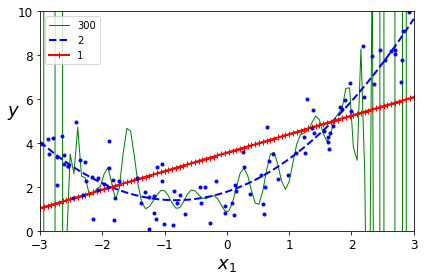

In [39]:
from IPython.display import Image
Image(filename='/content/handson_repo/bias_variance.png',width=1000,height=600) 

svm_clf


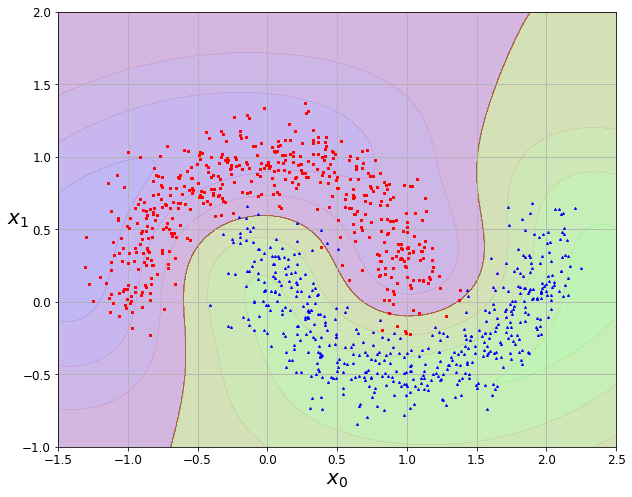

svm_clf_2


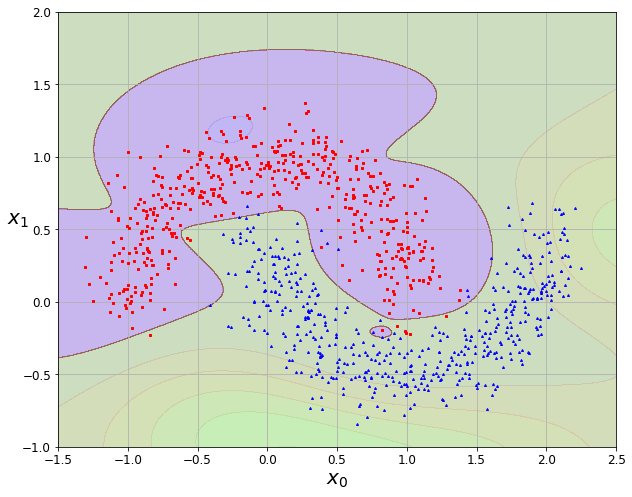

In [40]:
print("svm_clf")
plt.figure(figsize=(10,8))
plot_predictions(svm_clf,[-1.5,2.5,-1,2])
plot_dataset(X_moons_test,y_moons_test,[-1.5,2.5,-1,2])
plt.show()

print("svm_clf_2")
plt.figure(figsize=(10,8))
plot_predictions(svm_clf_non_reg,[-1.5,2.5,-1,2])
plot_dataset(X_moons_test,y_moons_test,[-1.5,2.5,-1,2])
plt.show()

# 3. Roleplay: Your virtual ( fake ) internship as a hotel company

Let's think of a scenario. You are selected as a **Machine Learning Intern** for a hotel company who wants to use Machine Learning to improve their businesses and workflows.

So, let's see in brief, how you will tackle a typical Machine Learning task:
- **Understanding** the task
- **Analysis** of Data to get a better understanding
- **Feature Engineering**
- **Preprocessing** your data
- Creating **test set**
- Selecting a relevant **performance metric**
- **Model training**
- **Hyperparameter tuning**
- **Deployment**

Note that, some of these steps might be iterative.

## Task: Predict cancellations of Hotel Bookings

Now, let's say that you have received your first task which is to predict whether the bookings for a particular reservation will be cancelled or not since it leads to a lot of loss for the company. The company has historical data of bookings along with a number of other parameters for each booking. The parameters along with their brief explanation are given as follows:

Link to dataset: https://docs.google.com/spreadsheets/d/19HY1IpJHbIUJqZIdkUNNW5ppnTdwps01NPBN7_45J88/edit?usp=sharing

| Feature Name | Feature Description |
|--------------|---------------------|
|hotel|Hotel (H1 = Resort Hotel or H2 = City Hotel)|	
|is_canceled|Value indicating if the booking was canceled (1) or not (0)|
|lead_time|Number of days that elapsed between the entering date of the booking into the PMS and the arrival date|
|arrival_date_year|Year of arrival date|
|arrival_date_month|Month of arrival date|
|arrival_date_week_number|Week number of year for arrival date|
|arrival_date_day_of_month|Day of arrival date|	
|stays_in_weekend_nights	|Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel|
|stays_in_week_nights	|Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel|
|adults|Number of adults|
|children|Number of children|
|babies|Number of babies|
|meal|Type of meal booked. Categories are presented in standard hospitality meal packages: Undefined/SC – no meal package; BB – Bed & Breakfast; HB – Half board (breakfast and one other meal – usually dinner); FB – Full board (breakfast, lunch and dinner)|
|country|Country of origin. Categories are represented in the ISO 3155–3:2013 format|
|market_segment|Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”|
|distribution_channel|Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”|
|is_repeated_guest|Value indicating if the booking name was from a repeated guest (1) or not (0)|
|previous_cancellations|Number of previous bookings that were cancelled by the customer prior to the current booking|
|previous_bookings_not_canceled|Number of previous bookings not cancelled by the customer prior to the current booking|
|reserved_room_type|Code of room type reserved. Code is presented instead of designation for anonymity reasons.|
|assigned_room_type|Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons|
|booking_changes|Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation|
|deposit_type|Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories:No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay.|
|agent|ID of the travel agency that made the booking|
|company|ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons|	
|days_in_waiting_list|Number of days the booking was in the waiting list before it was confirmed to the customer|
|customer_type|Type of booking, assuming one of four categories: Contract - when the booking has an allotment or other type of contract associated to it; Group – when the booking is associated to a group; Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party – when the booking is transient, but is associated to at least other transient booking|
|adr|Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights|
|required_car_parking_spaces|Number of car parking spaces required by the customer|
|total_of_special_requests|Number of special requests made by the customer (e.g. twin bed or high floor)|
|reservation_status|Reservation last status, assuming one of three categories: Canceled – booking was canceled by the customer;Check-Out – customer has checked in but already departed;No-Show – customer did not check-in and did inform the hotel of the reason why|
|reservation_status_date|Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to|

### Step 1: Understanding the problem

- Given the parameters of a booking reservation details, predict whether it will be cancelled or not. Therefore, target column is is_canceled.
- Note that this is a time-series based data ( arrival date being the temporal variable ). We have to keep some special things in mind when dealing with time series data.
- This is a big dataset ( containing 119390 entries ). So, we have to keep in mind that the algorithms that we use shouldn't have too bad of a runtime complexity ( i.e. it should be able to scale to this size ).

### Step 2: Analysis of Data

In [41]:
df=pd.read_csv('/content/handson_repo/hotel_bookings.csv') #Loads the csv into python in a special structure called DataFrame
df.head() #Shows the first few rows

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [42]:
df.shape #Shows (number of rows,number of columns)

(119390, 32)

In [43]:
print("# of NaN in each columns:", df.isnull().sum(), sep='\n') #Shows for each column the number of missing values, we need to deal with these later

# of NaN in each columns:
hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                          

In [44]:
# Making a copy of the dataset just incase the original version is needed somewhere else
data = df.copy()

In [45]:
data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [46]:
data.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

#### Knowledge Byte: Categorical vs Ordinal vs Numerical 

There are primarily three types of datapoints that you can have in tabular data:
- **Categorical**: These are the variables which take in only specific values but doesn't have any inherent ordering between them. For eg., colours.
- **Ordinal**: These are similar to categorical variables but they have an inherent ordering between them. For eg., month of year.
- **Numerical**: These are normal numerical values.

Depending on which model we are building, we might have to treat these different types of datapoints differently.

In [47]:
categorical_cols=['hotel','is_canceled','meal','country','market_segment','distribution_channel','is_repeated_guest','reserved_room_type',
                  'assigned_room_type','deposit_type','agent','company','customer_type','reservation_status']

In [48]:
for each_col in categorical_cols:
  data.loc[:,each_col]=data.loc[:,each_col].astype('str') #Setting the categorical variables as str type so that it is treated as a categorical type

In [49]:
data.dtypes

hotel                              object
is_canceled                        object
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                  object
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [50]:
data.describe(include='all')

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
count,119390,119390,119390.000000,119390.000000,119390,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390,119390,119390,119390,119390,119390.000000,119390.000000,119390,119390,119390.000000,119390,119390,119390,119390.000000,119390,119390.000000,119390.000000,119390.000000,119390,119390
unique,2,2,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,178,8,5,2,NaN,NaN,10,12,NaN,3,334,353,NaN,4,NaN,NaN,NaN,3,926
top,City Hotel,0,NaN,NaN,August,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB,PRT,Online TA,TA/TO,0,NaN,NaN,A,A,NaN,No Deposit,9.0,nan,NaN,Transient,NaN,NaN,NaN,Check-Out,2015-10-21
freq,79330,75166,NaN,NaN,13877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92310,48590,56477,97870,115580,NaN,NaN,85994,74053,NaN,104641,31961,112593,NaN,89613,NaN,NaN,NaN,75166,1461
mean,NaN,NaN,104.011416,2016.156554,NaN,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,NaN,NaN,NaN,NaN,NaN,0.087118,0.137097,NaN,NaN,0.221124,NaN,NaN,NaN,2.321149,NaN,101.831122,0.062518,0.571363,NaN,NaN
std,NaN,NaN,106.863097,0.707476,NaN,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,NaN,NaN,NaN,NaN,NaN,0.844336,1.497437,NaN,NaN,0.652306,NaN,NaN,NaN,17.594721,NaN,50.535790,0.245291,0.792798,NaN,NaN
min,NaN,NaN,0.000000,2015.000000,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,-6.380000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,18.000000,2016.000000,NaN,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,69.290000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,69.000000,2016.000000,NaN,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,94.575000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,160.000000,2017.000000,NaN,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,126.000000,0.000000,1.000000,NaN,NaN


#### Plotting the distribution of categorical classes

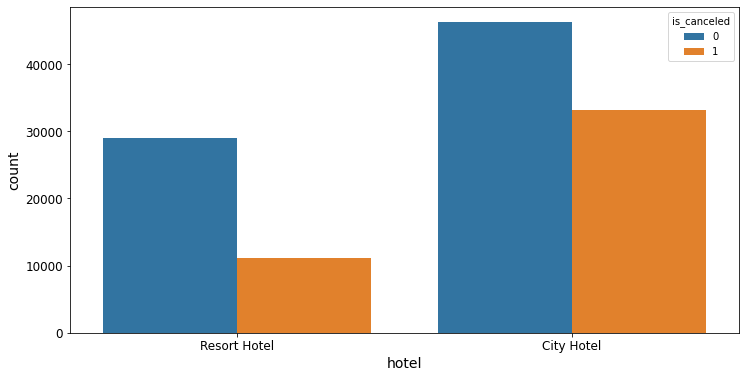

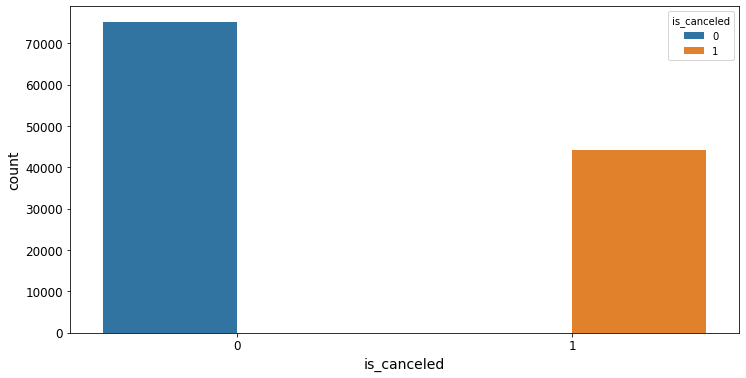

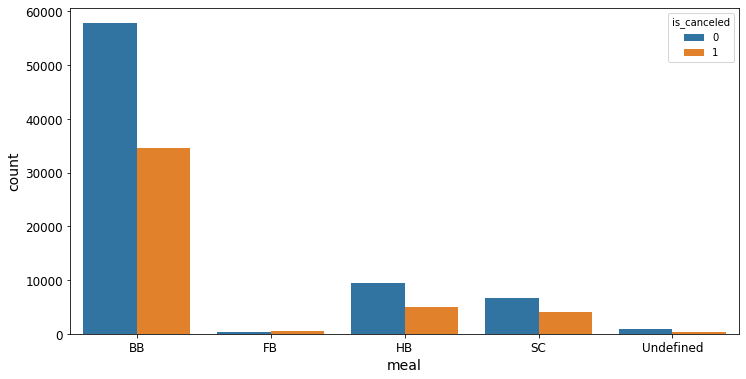

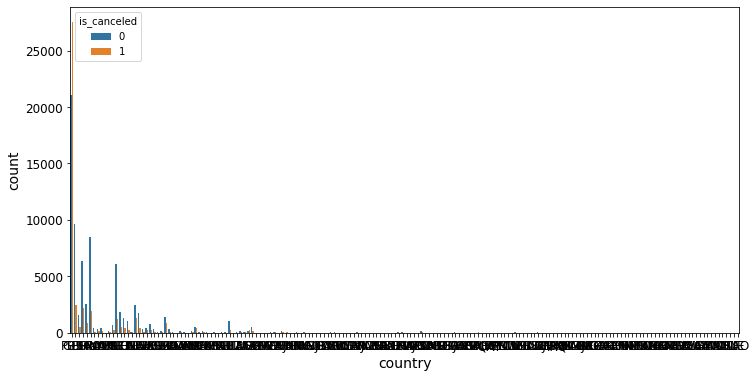

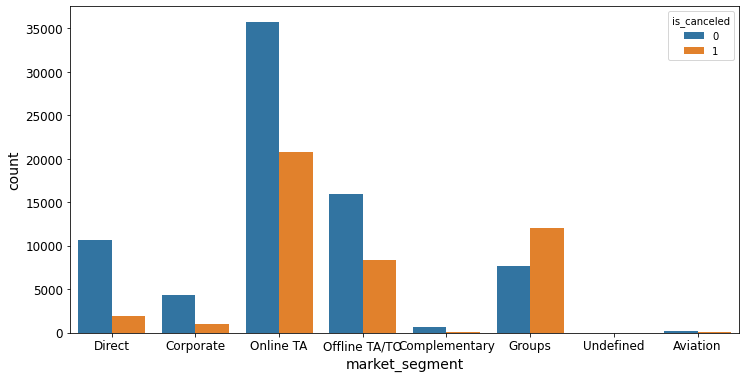

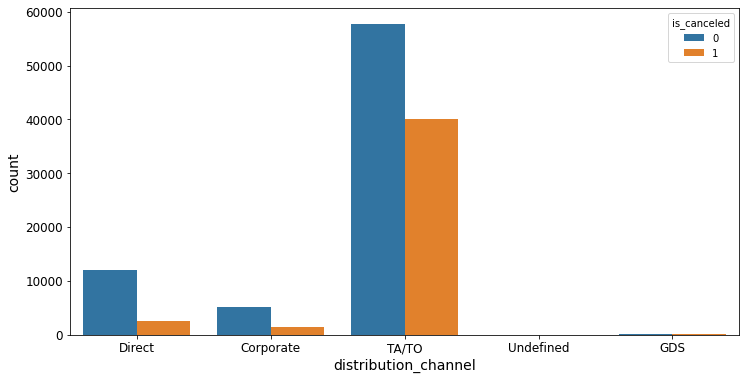

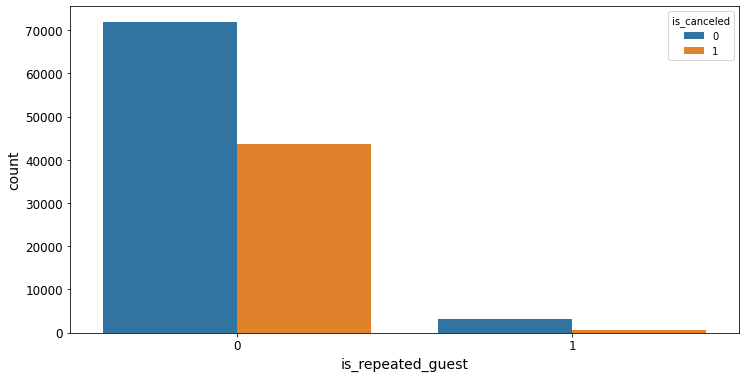

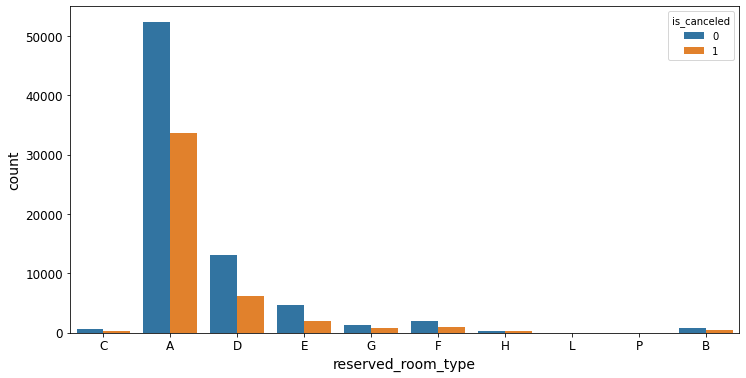

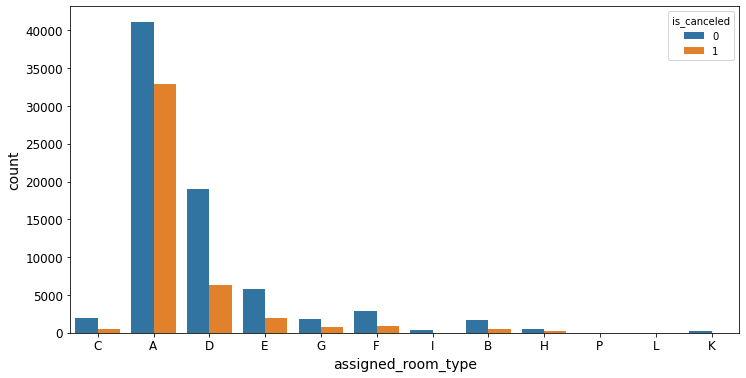

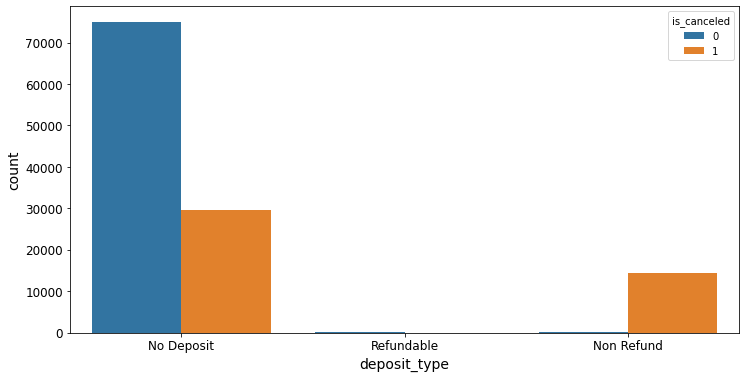

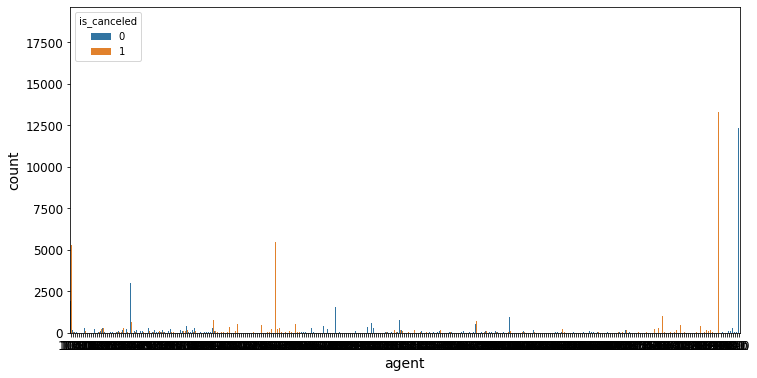

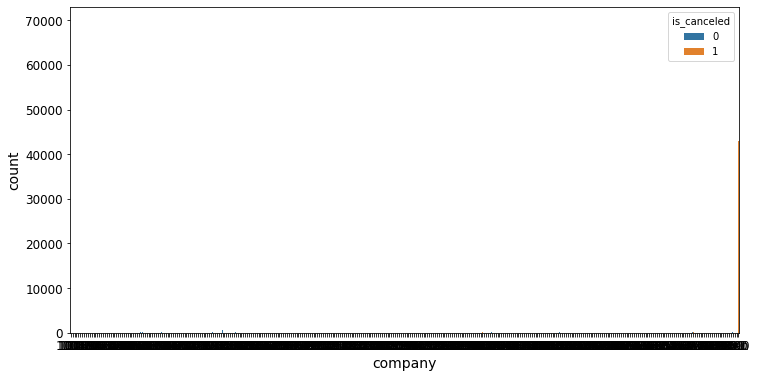

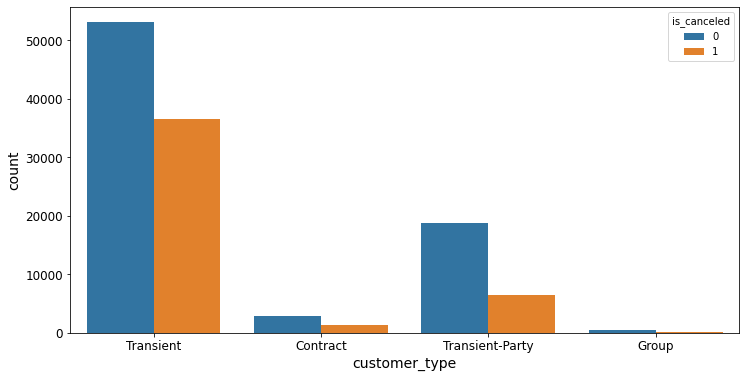

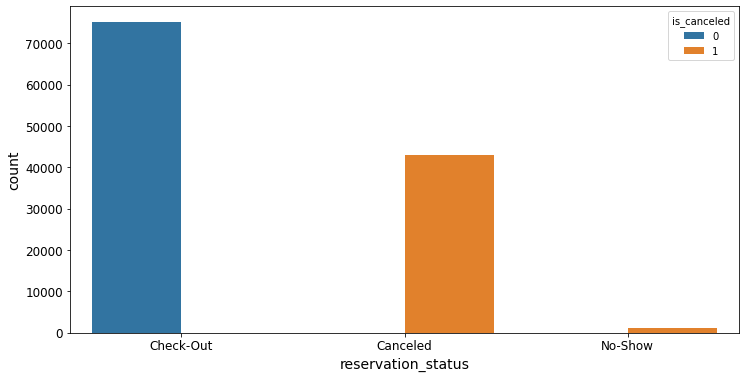

In [51]:
for each_col in categorical_cols:
  plt.figure(figsize=(12,6))
  ax=sns.countplot(x = each_col, hue = 'is_canceled', data = data)
  #ax.set_title(each_col)
  plt.show()

#### Distribution of the output ( target class )

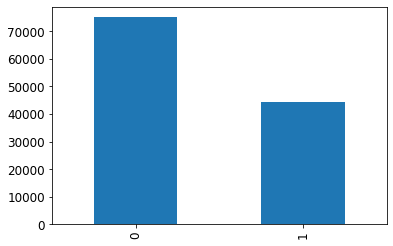

In [52]:
data.is_canceled.value_counts().plot(kind='bar') #it shows the count of is_canceled=True ( value = 1) and is_canceled=False ( value=0 )

In [53]:
data.is_canceled.value_counts()/data.shape[0] #percentage distribution

0    0.629584
1    0.370416
Name: is_canceled, dtype: float64

We can see that the output classes are not well balanced. Therefore, we need to keep that in mind while selecting a performance metric.

#### Histogram of Lead Time for Cancelation

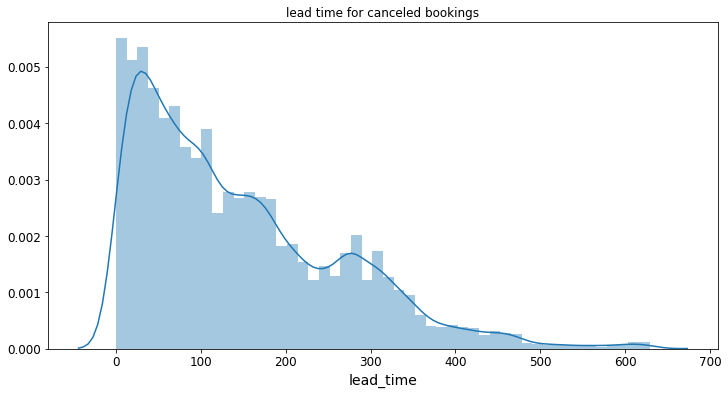

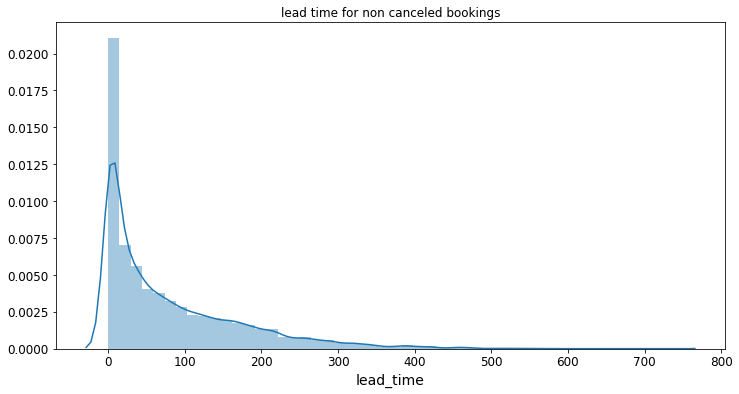

In [54]:
plt.figure(figsize=(12,6))
ax=sns.distplot(data.loc[data.is_canceled=='1','lead_time'])
ax.set_title('lead time for canceled bookings')
plt.show()
plt.figure(figsize=(12,6))
ax1=sns.distplot(data.loc[data.is_canceled=='0','lead_time'])
ax1.set_title('lead time for non canceled bookings')
plt.show()

#### Distribution of Cancelations Month Wise

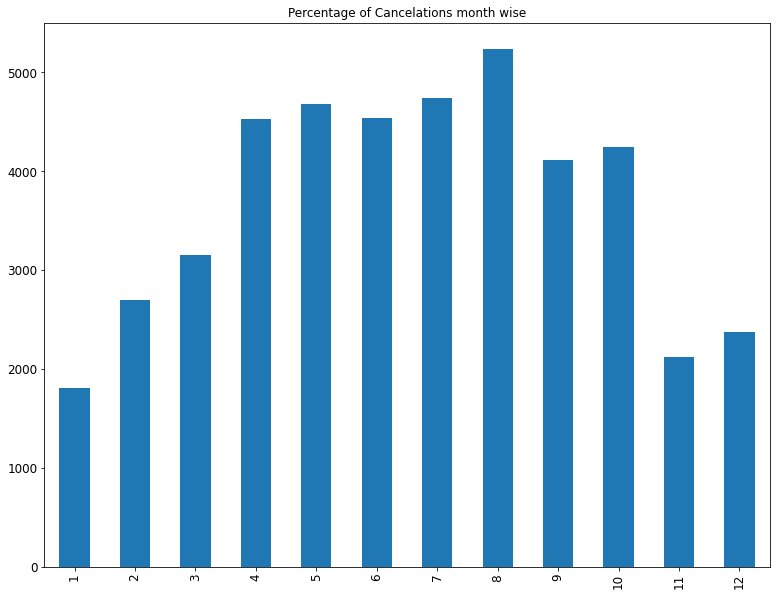

In [58]:
plt.figure(figsize = (13,10))
month_ordering=['January','February','March','April','May','June','July','August','September','October','November','December']
month_ordering_dict={k:i for i,k in enumerate(month_ordering,start=1)}
data_ser=data.loc[data.is_canceled=='1','arrival_date_month'].value_counts()
data_ser.index=data_ser.index.map(month_ordering_dict)
ax=(data_ser.sort_index()).plot(kind='bar')
ax.set_title('Percentage of Cancelations month wise')
plt.show()

In [59]:
pd.__version__

'1.0.5'

### Step 3: Feature Enginnering

- This is the step where you define additional features which you feel might help your model make better predictions.
- Although this step is optional, if used wisely, it can lead to big improvement in model performance.
- However for the sake of brevity, we wont delve deep into Feature Engineering in this webinar.

### Step 4: Preprocessing your data

#### 1. Removing columns which might lead to leakage

- We shouldn't have any columns which directly reveals the output ( target variable ) or the variables which we dont know in advance.
- In this case, **reservation_status**,**reservation_status_date**, **assigned_room_type**,**booking_changes** are such fields which we need to remove.

In [60]:
data.shape

(119390, 32)

In [61]:
data=data.drop(columns=['reservation_status','reservation_status_date','assigned_room_type','booking_changes']) #We have to drop this two columns because they can leak information about the target variable

In [62]:
categorical_cols.remove('reservation_status')
categorical_cols.remove('assigned_room_type')

In [63]:
data.shape

(119390, 28)

#### 2. Imputation ( Filling in missing values )

- Why do we need to deal with missing values in a dataset?
> We have to deal with them because the model can't inherently deal with missing values and so we have to make special modifications to the dataset to deal with missing values.
- Common ways to fix missing values:
 - For categorical variables, you can set the missing values as a seperate category
 - You can use the central tendencies ( mean, mode, median ) as suitable for your case to fill in the missing values.

- Which one to use is subjective and depends on your understanding of the dataset and which will be most suitable for your purpose.

In [64]:
print("# of NaN in each columns:", data.isnull().sum(), sep='\n') #Shows for each column the number of missing values

# of NaN in each columns:
hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          4
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
to

From the above list, we can see that we have missing values for 4 columns: 
- children
- country
- agent
- company

Let's see how we can deal with them.

In [65]:
data.children.value_counts() # Shows the frequency of values for children column

0.0     110796
1.0       4861
2.0       3652
3.0         76
10.0         1
Name: children, dtype: int64

In [66]:
data.country.value_counts()

PRT    48590
GBR    12129
FRA    10415
ESP     8568
DEU     7287
       ...  
MMR        1
KIR        1
PLW        1
BFA        1
HND        1
Name: country, Length: 178, dtype: int64

In [67]:
data.agent.value_counts()

9.0      31961
nan      16340
240.0    13922
1.0       7191
14.0      3640
         ...  
416.0        1
301.0        1
216.0        1
165.0        1
70.0         1
Name: agent, Length: 334, dtype: int64

In [68]:
data.company.value_counts()

nan      112593
40.0        927
223.0       784
67.0        267
45.0        250
          ...  
454.0         1
446.0         1
10.0          1
142.0         1
109.0         1
Name: company, Length: 353, dtype: int64

We can perhaps use the following strategy for filling missing values:
- children: use mode ( i.e. use the most frequent value, which is 0 )
- country: set a seperate category as unknown
- agent: set a seperate category as unknown
- company: set a seperate category as unknown

In [69]:
data=data.fillna(value={"children":0.0,"country":"unk","agent":"unk","company":"unk"})
data.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

#### Dealing with non integer ordinal variables

In [70]:
data.dtypes

hotel                              object
is_canceled                        object
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                  object
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
deposit_type                       object
agent                              object
company                            object
days_in_waiting_list              

In [71]:
data.arrival_date_month.value_counts()

August       13877
July         12661
May          11791
October      11160
April        11089
June         10939
September    10508
March         9794
February      8068
November      6794
December      6780
January       5929
Name: arrival_date_month, dtype: int64

In [72]:
month_ordering=['January','February','March','April','May','June','July','August','September','October','November','December']
data.loc[:,'arrival_date_month']=data.arrival_date_month.apply(lambda x:str(month_ordering.index(x)+1)).astype('int')
data.arrival_date_month.value_counts()

8     13877
7     12661
5     11791
10    11160
4     11089
6     10939
9     10508
3      9794
2      8068
11     6794
12     6780
1      5929
Name: arrival_date_month, dtype: int64

#### Dealing with Categorical variables

- Categorical variables because of the fact that they don't have any inherent ordering cant be fed directly into the model. Instead we have to resort to techniques like One Hot Encoding ( or more advanced techniques, that is out of scope for this session ) to feed them into the model.   
![One Hot Encoding Example](https://miro.medium.com/max/1200/0*T5jaa2othYfXZX9W.)

So, a column A with N unique values actually becomes N columns before you feed it into the Machine Learning Model.

In [73]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer

In [74]:
data.loc[:,categorical_cols].nunique() #Number of unique values for each columns

hotel                     2
is_canceled               2
meal                      5
country                 178
market_segment            8
distribution_channel      5
is_repeated_guest         2
reserved_room_type       10
deposit_type              3
agent                   334
company                 353
customer_type             4
dtype: int64

In [75]:
data.agent.value_counts().describe() #Distribution of value counts for agent

count      334.000000
mean       357.455090
std       2164.112713
min          1.000000
25%          3.000000
50%         24.000000
75%        103.000000
max      31961.000000
Name: agent, dtype: float64

In [76]:
data.company.value_counts().describe() #Distribution of value counts for company

count       353.000000
mean        338.215297
std        5992.105810
min           1.000000
25%           2.000000
50%           5.000000
75%          14.000000
max      112593.000000
Name: company, dtype: float64

In [77]:
data.country.value_counts().describe() #Distribution of value counts for country

count      178.000000
mean       670.730337
std       3920.057548
min          1.000000
25%          2.000000
50%         12.500000
75%         74.750000
max      48590.000000
Name: country, dtype: float64

To reduce the number of categories for country, company and agent, we will drop some of the categories that have very less entries. From the above three cells we can see that many of these categories have less than 5 entries, so we will drop those entries and represent it by a value called 'others'.

In [78]:
data_country_replace_values=[i for i,x in data.country.value_counts().iteritems() if x<5]
data_company_replace_values=[i for i,x in data.company.value_counts().iteritems() if x<5]
data_agent_replace_values=[i for i,x in data.agent.value_counts().iteritems() if x<5]
len(data_country_replace_values),len(data_company_replace_values),len(data_agent_replace_values)

(61, 175, 95)

In [79]:
data_country_replace_values[:5],data_company_replace_values[:5],data_agent_replace_values[:5]

(['PRY', 'ZWE', 'MCO', 'UZB', 'GHA'],
 ['353.0', '395.0', '445.0', '192.0', '185.0'],
 ['244.0', '341.0', '180.0', '403.0', '295.0'])

In [80]:
data.country=data.country.apply(lambda x:'oth' if x in data_country_replace_values else x)
data.company=data.company.apply(lambda x:'oth' if x in data_company_replace_values else x)
data.agent=data.agent.apply(lambda x:'oth' if x in data_agent_replace_values else x)

In [81]:
data.loc[:,categorical_cols].nunique()

hotel                     2
is_canceled               2
meal                      5
country                 118
market_segment            8
distribution_channel      5
is_repeated_guest         2
reserved_room_type       10
deposit_type              3
agent                   240
company                 179
customer_type             4
dtype: int64

In [82]:
(data.country=='oth').sum(),(data.company=='oth').sum(),(data.agent=='oth').sum()

(114, 325, 170)

In [83]:
(data.country=='oth').sum()/data.shape[0],(data.company=='oth').sum()/data.shape[0],(data.agent=='oth').sum()/data.shape[0]

(0.0009548538403551386, 0.002722171036100176, 0.0014239048496523998)

Now we can use One Hot Encoding to encode the categorical variables

In [84]:
categorical_df=data.loc[:,categorical_cols]
data.shape,categorical_df.shape

((119390, 28), (119390, 12))

In [85]:
data=data.sort_values(['arrival_date_year','arrival_date_month','arrival_date_day_of_month']) #The reason for doing this will be clear when we create validation and test set

In [86]:
column_ordering=list(data.columns)
column_ordering

['hotel',
 'is_canceled',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'deposit_type',
 'agent',
 'company',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [87]:
target_col='is_canceled'
features_col=[x for x in column_ordering if x!=target_col] 
features_col

['hotel',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'deposit_type',
 'agent',
 'company',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [88]:
data_X=data.loc[:,features_col]
data_y=data.loc[:,target_col]
data_X.shape,data_y.shape

((119390, 27), (119390,))

In [89]:
data_X.loc[:,'is_repeated_guest']=data_X.is_repeated_guest.apply(lambda x:str(float(x))) #Required later for deployment

In [90]:
data_y.head()

0    0
1    0
2    0
3    0
4    0
Name: is_canceled, dtype: object

In [91]:
data_y=data_y.astype('int')
data_y.head()

0    0
1    0
2    0
3    0
4    0
Name: is_canceled, dtype: int64

In [92]:
categorical_cols_X=[x for x in categorical_cols if x!=target_col]
len(categorical_cols),len(categorical_cols_X)

(12, 11)

In [93]:
col_idxs_categorical=[i for i,x in enumerate(features_col) if x in categorical_cols_X]
col_idxs_categorical,categorical_cols_X

([0, 11, 12, 13, 14, 15, 18, 19, 20, 21, 23],
 ['hotel',
  'meal',
  'country',
  'market_segment',
  'distribution_channel',
  'is_repeated_guest',
  'reserved_room_type',
  'deposit_type',
  'agent',
  'company',
  'customer_type'])

In [94]:
data_cat_X=data_X.loc[:,categorical_cols_X]
data_cat_X.shape

(119390, 11)

In [95]:
non_categorical_cols_X=[x for x in features_col if x not in categorical_cols_X]
non_categorical_cols_X

['lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [96]:
data_non_cat_X=data_X.loc[:,non_categorical_cols_X]
data_non_cat_X.shape

(119390, 16)

In [97]:
#Checking data types of categorical types
data_X.dtypes.loc[categorical_cols_X]

hotel                   object
meal                    object
country                 object
market_segment          object
distribution_channel    object
is_repeated_guest       object
reserved_room_type      object
deposit_type            object
agent                   object
company                 object
customer_type           object
dtype: object

In [98]:
#Checking data types of non categorical types
for i,value in data_X.dtypes.iteritems():
  if i not in categorical_cols_X:
    print((i,value))

('lead_time', dtype('int64'))
('arrival_date_year', dtype('int64'))
('arrival_date_month', dtype('int64'))
('arrival_date_week_number', dtype('int64'))
('arrival_date_day_of_month', dtype('int64'))
('stays_in_weekend_nights', dtype('int64'))
('stays_in_week_nights', dtype('int64'))
('adults', dtype('int64'))
('children', dtype('float64'))
('babies', dtype('int64'))
('previous_cancellations', dtype('int64'))
('previous_bookings_not_canceled', dtype('int64'))
('days_in_waiting_list', dtype('int64'))
('adr', dtype('float64'))
('required_car_parking_spaces', dtype('int64'))
('total_of_special_requests', dtype('int64'))


In [99]:
# columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(),col_idxs_categorical)], remainder='passthrough') #Does one hot encoding on our behalf


In [100]:
cat_encoder=OneHotEncoder(sparse=False) #sparse=False makes it memory intensive, but since Colab has significant ram we are going with this                

In [101]:
data_cat_X_enc=cat_encoder.fit_transform(data_cat_X.values)
data_cat_X_enc.shape

(119390, 576)

In [102]:
len(data_cat_X.columns),len(cat_encoder.categories_)

(11, 11)

In [103]:
type(data_cat_X_enc)

numpy.ndarray

In [104]:
cat_encoder.categories_ # Each of the values in these variables, OneHotEncoder has created a seperate column for

[array(['City Hotel', 'Resort Hotel'], dtype=object),
 array(['BB', 'FB', 'HB', 'SC', 'Undefined'], dtype=object),
 array(['AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'AUS', 'AUT', 'AZE',
        'BEL', 'BGD', 'BGR', 'BHR', 'BIH', 'BLR', 'BOL', 'BRA', 'CAF',
        'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'CN', 'COL', 'CPV', 'CRI',
        'CUB', 'CYP', 'CZE', 'DEU', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY',
        'ESP', 'EST', 'FIN', 'FRA', 'FRO', 'GBR', 'GEO', 'GIB', 'GNB',
        'GRC', 'HKG', 'HRV', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ',
        'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN',
        'KOR', 'KWT', 'LBN', 'LBY', 'LKA', 'LTU', 'LUX', 'LVA', 'MAC',
        'MAR', 'MDV', 'MEX', 'MKD', 'MLT', 'MNE', 'MOZ', 'MUS', 'MYS',
        'NGA', 'NLD', 'NOR', 'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL',
        'POL', 'PRI', 'PRT', 'QAT', 'ROU', 'RUS', 'SAU', 'SEN', 'SGP',
        'SRB', 'SUR', 'SVK', 'SVN', 'SWE', 'THA', 'TJK', 'TUN', 'TUR',
        'TWN', 'TZA', 'UKR', 'URY'

In [105]:
data_full_X_enc=np.concatenate((data_cat_X_enc,data_non_cat_X.values),axis=1)
data_full_X_enc.shape

(119390, 592)

In [106]:
data_cat_X_enc.shape,data_non_cat_X.values.shape #For verifying the shapes

((119390, 576), (119390, 16))

In [107]:
all_features=[]
for col,each_cat_val in zip(data_cat_X.columns,cat_encoder.categories_): #Add the categorical columns
  for each_val in each_cat_val:
    all_features.append((col,each_val))
all_features.extend([(x,) for x in data_non_cat_X.columns]) #Add the non categorial columns
len(all_features)

592

In [108]:
all_features[:25]

[('hotel', 'City Hotel'),
 ('hotel', 'Resort Hotel'),
 ('meal', 'BB'),
 ('meal', 'FB'),
 ('meal', 'HB'),
 ('meal', 'SC'),
 ('meal', 'Undefined'),
 ('country', 'AGO'),
 ('country', 'ALB'),
 ('country', 'AND'),
 ('country', 'ARE'),
 ('country', 'ARG'),
 ('country', 'ARM'),
 ('country', 'AUS'),
 ('country', 'AUT'),
 ('country', 'AZE'),
 ('country', 'BEL'),
 ('country', 'BGD'),
 ('country', 'BGR'),
 ('country', 'BHR'),
 ('country', 'BIH'),
 ('country', 'BLR'),
 ('country', 'BOL'),
 ('country', 'BRA'),
 ('country', 'CAF')]

In [109]:
assert len(all_features)==data_full_X_enc.shape[1]

We will save some additional stuff related to preprocessing steps using joblib, in the same way that we saved the model. This will be required later for the section **Dummy Deployment**.

In [110]:
preprocessing_info_dump={'cat_cols':categorical_cols_X, #Saves the names and ordering of the categorical cols
                         'non_cat_cols':non_categorical_cols_X, #Saves the names and ordering of the non-categorical cols
                         'full_expanded_col_size':data_full_X_enc.shape[1] #Saves the total column length after expansion....This is saved just for verification as shown later
                         }

In [111]:
dump(cat_encoder,'handson_repo/cat_encoder.pkl') #Dumping the OneHotEncoder Transformer
dump(preprocessing_info_dump,'handson_repo/preprocessing_info.pkl') #Dumping preprocessing info which will be required during deployment

['handson_repo/preprocessing_info.pkl']

### Step 5: Creating test set

- As shown in an earlier section, for the model to generalize, it is important that we measure its performance on datapoints which were not part of the training but belongs to the same dataset to get a good estimate of the performance. Therefore, we divide the dataset into two parts: **Training** and **Validation** Set.  
- However, in a lot of cases, there is a third partition of the dataset which is present which is used for getting the final performance of the model. That is called the **Holdout** set. That is because the validation set is used to try out different models, hyperparameters and select the best model. Thus, if we try out a lot of combinations using the validation set, we are somewhat overfitting the final model to the validation set too. That is where the Holdout set comes into picture.
![train,val,test split](https://miro.medium.com/max/1552/1*Nv2NNALuokZEcV6hYEHdGA.png)
- A typical division between Training, Validation and Holdout might be 80%,10%,10% of the total samples respectively. 

- For our particular dataset, we can see that it is a time-series aware dataset i.e. there is a date or time component in our dataset. Therefore we have to take validation and test only from the end.
- The reason for this is because in real life, we can't get data from the future to predict the past. We can only have data from the past to train on and then predict the future using only the past data. This is why we had sorted the dataset according to the time component earlier.

In [112]:
train_set_perc=0.80
test_set_perc=0.10
val_set_perc=0.10
assert train_set_perc+test_set_perc+val_set_perc==1.0 # Logical check

In [113]:
train_len=int(train_set_perc*data_full_X_enc.shape[0])
test_len=int(test_set_perc*data_full_X_enc.shape[0])
val_len=data_full_X_enc.shape[0]-train_len-test_len
train_len,test_len,val_len

(95512, 11939, 11939)

In [114]:
train_set_idxs_range=(0,train_len) #(start_idx,end_idx) start_idx is inclusive and end_idx is exclusive
test_set_idxs_range=(train_len,train_len+test_len) #(start_idx,end_idx) start_idx is inclusive and end_idx is exclusive
val_set_idxs_range=(train_len+test_len,data_full_X_enc.shape[0])
train_set_idxs_range,test_set_idxs_range,val_set_idxs_range

((0, 95512), (95512, 107451), (107451, 119390))

In [115]:
data_train_X=data_full_X_enc[train_set_idxs_range[0]:train_set_idxs_range[1]]
data_test_X=data_full_X_enc[test_set_idxs_range[0]:test_set_idxs_range[1]]
data_val_X=data_full_X_enc[val_set_idxs_range[0]:val_set_idxs_range[1]]
data_train_y=data_y.values[train_set_idxs_range[0]:train_set_idxs_range[1]]
data_test_y=data_y.values[test_set_idxs_range[0]:test_set_idxs_range[1]]
data_val_y=data_y.values[val_set_idxs_range[0]:val_set_idxs_range[1]]

assert data_train_X.shape[0]==train_len
assert data_val_X.shape[0]==val_len
assert data_test_X.shape[0]==test_len
assert data_train_y.shape[0]==train_len
assert data_val_y.shape[0]==val_len
assert data_test_y.shape[0]==test_len
(data_train_X.shape,data_val_X.shape,data_test_X.shape,data_train_y.shape,data_val_y.shape,data_test_y.shape)

((95512, 592), (11939, 592), (11939, 592), (95512,), (11939,), (11939,))

### Step 6: Selecting a performance metric

- Performance metric gives you a quantitative assessment of the performance of your model on a particular dataset.
- Selecting a good performance metric is very important since based on that, you will take a lot of decisions.
- You have to select a performance metric which suits the problem that you want to tackle.
- For example, in our dataset, we have ( moderate ) imbalanced output class distribution, so we should use a metric accordinglt. For this dataset, we will use **F1 score** ( combination of **precision** and **recall** ) as the performance metric.

- **Confusion Matrix**: Confusion matrix is a way of visualizing the model predictions against the known ground truth. See the image below for an example of a confusion matrix for a 2 class classification problem.
> ![conf matrix](https://miro.medium.com/max/415/1*uR09zTlPgIj5PvMYJZScVg.png)
![pregnant analogy for type 1 type 2 error](https://miro.medium.com/max/462/1*7EYylA6XlXSGBCF77j_rOA.png)

- **Precision**: Out of all the predictions made by a model, how many are actually correct?
- **Recall**: Out of all the samples, how many were correctly predicted ( i.e. recalled ) by the model?
- **F1 Score**: F1 Score gives you a way of combining both precision and recall in a single metric.
$$F_1 = \frac{2}{\mathrm{recall}^{-1} + \mathrm{precision}^{-1}} = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$.

In [116]:
from sklearn.metrics import f1_score,precision_score,recall_score,plot_confusion_matrix

### Step 7: Building Models

#### Trying Logistic Regression

In [117]:
# Retrain model Setting for Logistic Regression

train_model = "False"  #@param ["True","False"]
model_file_path= "/content/handson_repo/log_clf_hotels.pkl" #@param

In [118]:
if train_model=="False":
  assert Path("{}".format(model_file_path)).exists(),"Hey, you don't have the model file already saved...so looks like you will have to change\
   train_model to True to retrain the model or load the model file ( {} )".format(model_file_path)

In [119]:

%%time 
#Takes approx 30 secs to train
if train_model=="True":
  log_clf_hotels=Pipeline([
          ("scaler", StandardScaler()),
          ("log_reg", LogisticRegression(random_state=42,max_iter=1000,C=10)),
      ])
  log_clf_hotels.fit(data_train_X,data_train_y)
  dump(log_clf_hotels,model_file_path)
else:
  log_clf_hotels=load(model_file_path)

CPU times: user 2.61 ms, sys: 36 µs, total: 2.65 ms
Wall time: 2.35 ms


In [120]:
yhat_val=log_clf_hotels.predict(data_val_X) #Predictions on val set
yhat_val[:5]

array([0, 0, 0, 0, 0])

In [121]:
precision_score(data_val_y,yhat_val),recall_score(data_val_y,yhat_val),f1_score(data_val_y,yhat_val)

(0.6129478968322659, 0.7854924578527063, 0.6885755955274672)

<Figure size 864x576 with 0 Axes>

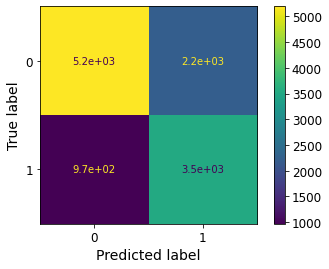

In [122]:
plt.figure(figsize=(12,8))
plot_confusion_matrix(log_clf_hotels,data_val_X,data_val_y)

#### Trying SVM Classifier

The hyper-parameters that we used for SVM in moons dataset ( rbf kernel ) are not feasible here because of dataset size. Hence we have to use SVM with linear kernel here.

In [123]:
from sklearn.svm import LinearSVC

In [124]:
# Retrain model Setting for Logistic Regression

train_model = "False"  #@param ["True","False"]
model_file_path= "/content/handson_repo/svm_clf_hotels.pkl" #@param

In [125]:
if train_model=="False":
  assert Path("{}".format(model_file_path)).exists(),"Hey, you don't have the model file already saved...so looks like you will have to change\
   train_model to True to retrain the model or load the model file ( {} )".format(model_file_path)

In [126]:
%%time
#Takes approx 1 min to train
if train_model=='True':
  svm_clf_hotels=Pipeline([
          ("scaler", StandardScaler()),
          ("svm_clf", LinearSVC(dual=False,C=10)),
      ])
  svm_clf_hotels.fit(data_train_X,data_train_y)
  dump(svm_clf_hotels,model_file_path)
else:
  svm_clf_hotels=load(model_file_path)

CPU times: user 1.95 ms, sys: 0 ns, total: 1.95 ms
Wall time: 6.44 ms


In [127]:
yhat_val=svm_clf_hotels.predict(data_val_X) #Predictions on val set
yhat_val[:5]

array([0, 0, 0, 0, 0])

In [128]:
precision_score(data_val_y,yhat_val),recall_score(data_val_y,yhat_val),f1_score(data_val_y,yhat_val)

(0.6200634696755994, 0.7801685891748004, 0.6909626719056974)

<Figure size 864x576 with 0 Axes>

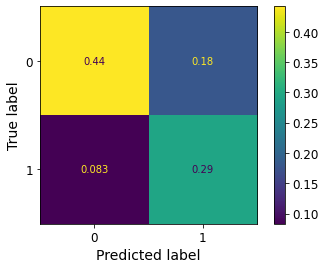

In [129]:
plt.figure(figsize=(12,8))
plot_confusion_matrix(svm_clf_hotels,data_val_X,data_val_y,normalize='all')

#### Using Gradient Boosted Decision Trees ( XGBoost )

- At the core of Boosted Trees algorithm, is a type of model called **Decision Trees**. It's a hierarchial set of conditions which the data is passed through to arrive at a decision. A sample decision tree is shown here:
  ![Decision Tree](https://miro.medium.com/max/484/1*gql3YU01S-BUiCt8mgE66w.png)
- It provides much more explanability as you can see how the decisions are made.
- You can even train multiple trees at once and use the combined output to arrive at a final decision. The idea is that the collective decision of many is better than the decision of one. This idea is called **ensembling**.
- When ensembling is done with Decision Trees, it is also known as **Random Forest**.
  ![Random Forest](https://miro.medium.com/max/2612/0*f_qQPFpdofWGLQqc.png)
- Gradient Boosted Decision Trees are an advanced form of Random Forest, the details of which are beyond the scope for this session.
- We will be using a library called XGBoost.
- XGBoost doesn't require **normalization**.

In [130]:
from xgboost import XGBClassifier

In [131]:
# Retrain model Setting for Logistic Regression

train_model = "False"  #@param ["True","False"]
model_file_path= "/content/handson_repo/xgb_clf_hotels.pkl" #@param

In [132]:
if train_model=="False":
  assert Path("{}".format(model_file_path)).exists(),"Hey, you don't have the model file already saved...so looks like you will have to change\
   train_model to True to retrain the model or load the model file ( {} )".format(model_file_path)

In [133]:
%%time
#Takes around 11 min to train
if train_model=='True':
  xgb_classifier_hotels=XGBClassifier(max_depth=5,n_estimators=500,verbosity=1,n_jobs=-1,seed=32)
  xgb_classifier_hotels.fit(data_train_X,data_train_y)
  dump(xgb_classifier_hotels,model_file_path)
else:
  xgb_classifier_hotels=load(model_file_path)

CPU times: user 13.6 ms, sys: 5.07 ms, total: 18.7 ms
Wall time: 115 ms


In [134]:
yhat_val=xgb_classifier_hotels.predict(data_val_X) #Predictions on val set
yhat_val[:5]

array([1, 0, 0, 0, 0])

In [135]:
precision_score(data_val_y,yhat_val),recall_score(data_val_y,yhat_val),f1_score(data_val_y,yhat_val)

(0.7164850781620086, 0.6710292812777284, 0.693012600229095)

In [136]:
yhat_train=xgb_classifier_hotels.predict(data_train_X)
precision_score(yhat_train,data_train_y),recall_score(yhat_train,data_train_y),f1_score(yhat_train,data_train_y)

(0.8086921202274574, 0.8816143214093684, 0.8435802375728229)

<Figure size 864x576 with 0 Axes>

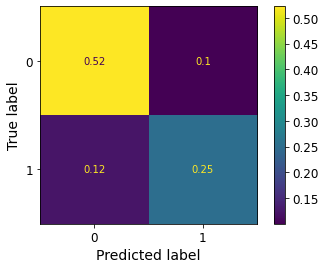

In [137]:
plt.figure(figsize=(12,8))
plot_confusion_matrix(xgb_classifier_hotels,data_val_X,data_val_y,normalize='all')

### Step 8: Hyper-parameter tuning

- As introduced earlier, hyper-parameters control how the model behaves.
- We now will try different combinations of hyper-parameters to see what might work best.
- Note that there's no one correct way to do this. Because training the model each time takes time and resources. So depending on how much time and resources we have, we can try different hyper-parameters.
- It is also important that we understand what each of the hyper-parameters do so that we are able to set reasonable values.
- We will only do hyper-parameter tuning for XGBoost and not for LogisticRegression and SVM although the process will be similar.

In [138]:
# Retrain model Setting for Logistic Regression
train_model = "If Not Exists"  #@param ["True","False","If Not Exists"]
model_file_path_prepend= "/content/handson_repo/xgb_grid" #@param

In [139]:
params_grid_1={'min_child_weight':[1,3,5],
             'max_depth':[3,5,7],
             'gamma':[0,0.50,1.0],
}

In [140]:
%%time
#Takes around 80 mins to train
performance_data_df=run_hyper_params_grid_search(params_grid_1,XGBClassifier,{'n_jobs':-1,'random_state':56},model_file_path_prepend,train_model)

{'gamma': 0, 'max_depth': 3, 'min_child_weight': 1, 'precision': 0.558340727595386, 'recall': 0.7318988077929631, 'f1_score': 0.6334465836164591, 'model_path': '/content/handson_repo/xgb_grid_gamma_0_max_depth_3_min_child_weight_1.pkl'}
{'gamma': 0, 'max_depth': 3, 'min_child_weight': 3, 'precision': 0.5554569653948536, 'recall': 0.7347417840375586, 'f1_score': 0.632642748863062, 'model_path': '/content/handson_repo/xgb_grid_gamma_0_max_depth_3_min_child_weight_3.pkl'}
{'gamma': 0, 'max_depth': 3, 'min_child_weight': 5, 'precision': 0.5590062111801242, 'recall': 0.733838089691322, 'f1_score': 0.6346008562075044, 'model_path': '/content/handson_repo/xgb_grid_gamma_0_max_depth_3_min_child_weight_5.pkl'}
{'gamma': 0, 'max_depth': 5, 'min_child_weight': 1, 'precision': 0.6015971606033718, 'recall': 0.7218525419217461, 'f1_score': 0.6562613430127042, 'model_path': '/content/handson_repo/xgb_grid_gamma_0_max_depth_5_min_child_weight_1.pkl'}
{'gamma': 0, 'max_depth': 5, 'min_child_weight': 3,

In [141]:
performance_data_df.sort_values('f1_score',ascending=False)

,gamma,max_depth,min_child_weight,precision,recall,f1_score,model_path
15,0.5,7,1,0.658385,0.725495,0.690313,/content/handson_repo/xgb_grid_gamma_0.5_max_d...
17,0.5,7,5,0.654836,0.720527,0.686113,/content/handson_repo/xgb_grid_gamma_0.5_max_d...
8,0.0,7,5,0.646850,0.728454,0.685231,/content/handson_repo/xgb_grid_gamma_0_max_dep...
7,0.0,7,3,0.644854,0.724035,0.682154,/content/handson_repo/xgb_grid_gamma_0_max_dep...
16,0.5,7,3,0.642857,0.725952,0.681882,/content/handson_repo/xgb_grid_gamma_0.5_max_d...
25,1.0,7,3,0.637977,0.729579,0.680710,/content/handson_repo/xgb_grid_gamma_1.0_max_d...
26,1.0,7,5,0.641970,0.721156,0.679263,/content/handson_repo/xgb_grid_gamma_1.0_max_d...
6,0.0,7,1,0.632653,0.728853,0.677354,/content/handson_repo/xgb_grid_gamma_0_max_dep...
24,1.0,7,1,0.613132,0.731217,0.666988,/content/handson_repo/xgb_grid_gamma_1.0_max_d...
14,0.5,5,5,0.617347,0.720238,0.664835,/content/handson_repo/xgb_grid_gamma_0.5_max_d...


In [142]:
params_grid_2={'max_depth':[7,9,11]}

In [143]:
%%time
#Takes around 12 mins to train
performance_data_df=run_hyper_params_grid_search(params_grid_2,XGBClassifier,{'n_jobs':-1,'random_state':56,'gamma':0.5,'min_child_weight':1},model_file_path_prepend,train_model)

{'max_depth': 7, 'precision': 0.6583850931677019, 'recall': 0.7254949890002445, 'f1_score': 0.6903128270729155, 'model_path': '/content/handson_repo/xgb_grid_max_depth_7.pkl'}
{'max_depth': 9, 'precision': 0.6555013309671694, 'recall': 0.726401179941003, 'f1_score': 0.6891324626865671, 'model_path': '/content/handson_repo/xgb_grid_max_depth_9.pkl'}
{'max_depth': 11, 'precision': 0.6479591836734694, 'recall': 0.7385587863463969, 'f1_score': 0.6902989483634645, 'model_path': '/content/handson_repo/xgb_grid_max_depth_11.pkl'}
CPU times: user 661 ms, sys: 2.9 ms, total: 664 ms
Wall time: 414 ms


In [144]:
params_grid_3={'subsample':[0.70,0.80,0.90,1],
             'colsample_bytree':[0.70,0.80,0.90,1]
}

In [145]:
%%time
#Takes around 50 mins to train
performance_data_df=run_hyper_params_grid_search(params_grid_3,XGBClassifier,{'n_jobs':-1,'random_state':56,'gamma':0.5,'min_child_weight':1,'max_depth':7},model_file_path_prepend,train_model)

{'colsample_bytree': 0.7, 'subsample': 0.7, 'precision': 0.6184560780834073, 'recall': 0.7369812318265927, 'f1_score': 0.6725364853455554, 'model_path': '/content/handson_repo/xgb_grid_colsample_bytree_0.7_subsample_0.7.pkl'}
{'colsample_bytree': 0.7, 'subsample': 0.8, 'precision': 0.6180124223602484, 'recall': 0.7333508818110029, 'f1_score': 0.6707596003370652, 'model_path': '/content/handson_repo/xgb_grid_colsample_bytree_0.7_subsample_0.8.pkl'}
{'colsample_bytree': 0.7, 'subsample': 0.9, 'precision': 0.6455190771960958, 'recall': 0.7242409158785466, 'f1_score': 0.6826178747361014, 'model_path': '/content/handson_repo/xgb_grid_colsample_bytree_0.7_subsample_0.9.pkl'}
{'colsample_bytree': 0.7, 'subsample': 1, 'precision': 0.6279946761313221, 'recall': 0.7355157183684073, 'f1_score': 0.6775158549718797, 'model_path': '/content/handson_repo/xgb_grid_colsample_bytree_0.7_subsample_1.pkl'}
{'colsample_bytree': 0.8, 'subsample': 0.7, 'precision': 0.6271073646850044, 'recall': 0.73524057217

In [146]:
performance_data_df.sort_values('f1_score',ascending=False)

,colsample_bytree,subsample,precision,recall,f1_score,model_path
13,1.0,0.8,0.659716,0.725897,0.691226,/content/handson_repo/xgb_grid_colsample_bytre...
15,1.0,1.0,0.658385,0.725495,0.690313,/content/handson_repo/xgb_grid_colsample_bytre...
8,0.9,0.7,0.664153,0.717469,0.689782,/content/handson_repo/xgb_grid_colsample_bytre...
9,0.9,0.8,0.651287,0.728898,0.687910,/content/handson_repo/xgb_grid_colsample_bytre...
12,1.0,0.7,0.650621,0.722236,0.684561,/content/handson_repo/xgb_grid_colsample_bytre...
6,0.8,0.9,0.644854,0.729303,0.684483,/content/handson_repo/xgb_grid_colsample_bytre...
11,0.9,1.0,0.643744,0.729879,0.684111,/content/handson_repo/xgb_grid_colsample_bytre...
2,0.7,0.9,0.645519,0.724241,0.682618,/content/handson_repo/xgb_grid_colsample_bytre...
10,0.9,0.9,0.635759,0.731682,0.680356,/content/handson_repo/xgb_grid_colsample_bytre...
3,0.7,1.0,0.627995,0.735516,0.677516,/content/handson_repo/xgb_grid_colsample_bytre...


In [147]:
params_grid_4 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05,0.0005,0.0001,0.00001],
 'n_estimators':[500]
}

In [148]:
%%time
#Takes around 120 mins to train
performance_data_df=run_hyper_params_grid_search(params_grid_4,XGBClassifier,{'n_jobs':-1,'random_state':56,'gamma':0.5,'min_child_weight':1,'max_depth':7,'colsample_bytree':1.0,'subsample':0.8},model_file_path_prepend,train_model)

{'n_estimators': 500, 'reg_alpha': 0, 'precision': 0.6561668145519077, 'recall': 0.7232273838630807, 'f1_score': 0.6880669923237963, 'model_path': '/content/handson_repo/xgb_grid_n_estimators_500_reg_alpha_0.pkl'}
{'n_estimators': 500, 'reg_alpha': 0.001, 'precision': 0.6818988464951198, 'recall': 0.7153828252269024, 'f1_score': 0.6982396365701306, 'model_path': '/content/handson_repo/xgb_grid_n_estimators_500_reg_alpha_0.001.pkl'}
{'n_estimators': 500, 'reg_alpha': 0.005, 'precision': 0.6641526175687666, 'recall': 0.7252906976744186, 'f1_score': 0.6933765632237147, 'model_path': '/content/handson_repo/xgb_grid_n_estimators_500_reg_alpha_0.005.pkl'}
{'n_estimators': 500, 'reg_alpha': 0.01, 'precision': 0.6752440106477373, 'recall': 0.7143862942971133, 'f1_score': 0.6942638841373018, 'model_path': '/content/handson_repo/xgb_grid_n_estimators_500_reg_alpha_0.01.pkl'}
{'n_estimators': 500, 'reg_alpha': 0.05, 'precision': 0.6681455190771961, 'recall': 0.7183400906272359, 'f1_score': 0.6923

In [149]:
performance_data_df.sort_values('f1_score',ascending=False)

,n_estimators,reg_alpha,precision,recall,f1_score,model_path
1,500,0.00100,0.681899,0.715383,0.698240,/content/handson_repo/xgb_grid_n_estimators_50...
6,500,0.00010,0.674357,0.721234,0.697008,/content/handson_repo/xgb_grid_n_estimators_50...
3,500,0.01000,0.675244,0.714386,0.694264,/content/handson_repo/xgb_grid_n_estimators_50...
2,500,0.00500,0.664153,0.725291,0.693377,/content/handson_repo/xgb_grid_n_estimators_50...
4,500,0.05000,0.668146,0.718340,0.692334,/content/handson_repo/xgb_grid_n_estimators_50...
0,500,0.00000,0.656167,0.723227,0.688067,/content/handson_repo/xgb_grid_n_estimators_50...
7,500,0.00001,0.656167,0.723227,0.688067,/content/handson_repo/xgb_grid_n_estimators_50...
5,500,0.00050,0.653061,0.724588,0.686968,/content/handson_repo/xgb_grid_n_estimators_50...


In [150]:
# Retrain model Setting for Finetuned model
train_model = "If Not Exists"  #@param ["True","False","If Not Exists"]
model_file_path_prepend= "/content/handson_repo/xgb_grid" #@param

In [151]:
%%time
#Takes around 18 min to train
model_file_path=model_file_path_prepend+'_tuned.pkl'
if train_model=='True' or ( train_model=='If Not Exists' and not Path(model_file_path).exists()):
  xgb_classifier_hotels_tuned=XGBClassifier(n_estimators=500,gamma=0.5,min_child_weight=1,max_depth=7,colsample_bytree=1.0,subsample=0.8,n_jobs=-1,random_state=56,reg_alpha=0.001)
  xgb_classifier_hotels_tuned.fit(data_train_X,data_train_y)
  dump(xgb_classifier_hotels_tuned,model_file_path)
else:
  xgb_classifier_hotels_tuned=load(model_file_path)

CPU times: user 6.57 ms, sys: 1.04 ms, total: 7.6 ms
Wall time: 7.57 ms


In [152]:
yhat_val=xgb_classifier_hotels_tuned.predict(data_val_X) #Predictions on val set
yhat_val[:5]

array([1, 0, 0, 0, 0])

In [153]:
precision_score(data_val_y,yhat_val),recall_score(data_val_y,yhat_val),f1_score(data_val_y,yhat_val)

(0.7153828252269024, 0.6818988464951198, 0.6982396365701306)

<Figure size 864x576 with 0 Axes>

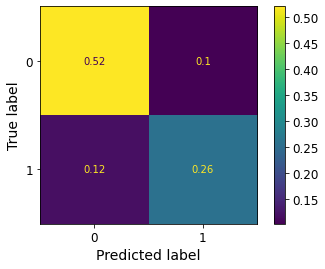

In [154]:
plt.figure(figsize=(12,8))
plot_confusion_matrix(xgb_classifier_hotels_tuned,data_val_X,data_val_y,normalize='all')

### Step 9: Insight into how your model is behaving

- For some model architectures, we can get some degree of explanability like in decision trees.
- The other very helpful thing is to actually look at the predictions that went wrong and try to find reasons why it might have gone wrong and take decisions based on that.
- The closer the feature is to the root node of a tree, the more important it is.
- For this model, we can calculate feature importance for each feature.

In [155]:
feature_importances_df=pd.DataFrame({"feature_name":all_features,"importance":xgb_classifier_hotels_tuned.feature_importances_}).sort_values('importance',ascending=False)
feature_importances_df.loc[:,'parent_feature_name']=feature_importances_df.feature_name.apply(lambda x:x[0])
feature_importances_df.head(50)

,feature_name,importance,parent_feature_name
151,"(deposit_type, Non Refund)",0.450077,deposit_type
586,"(previous_cancellations,)",0.035642,previous_cancellations
590,"(required_car_parking_spaces,)",0.034541,required_car_parking_spaces
383,"(agent, 9.0)",0.022978,agent
131,"(market_segment, Online TA)",0.022637,market_segment
236,"(agent, 240.0)",0.017327,agent
198,"(agent, 17.0)",0.015374,agent
99,"(country, PRT)",0.015264,country
591,"(total_of_special_requests,)",0.009096,total_of_special_requests
587,"(previous_bookings_not_canceled,)",0.008544,previous_bookings_not_canceled


In [156]:
#Feature importance by parent feature name
feature_importances_df.groupby('parent_feature_name')['importance'].sum().sort_values(ascending=False)

parent_feature_name
deposit_type                      0.451272
agent                             0.203804
country                           0.112351
market_segment                    0.036819
company                           0.036297
previous_cancellations            0.035642
required_car_parking_spaces       0.034541
customer_type                     0.015310
reserved_room_type                0.011840
meal                              0.010402
total_of_special_requests         0.009096
distribution_channel              0.008913
previous_bookings_not_canceled    0.008544
arrival_date_year                 0.005276
lead_time                         0.003052
days_in_waiting_list              0.002814
is_repeated_guest                 0.001691
hotel                             0.001565
arrival_date_week_number          0.001425
adults                            0.001396
stays_in_weekend_nights           0.001314
stays_in_week_nights              0.001300
adr                               

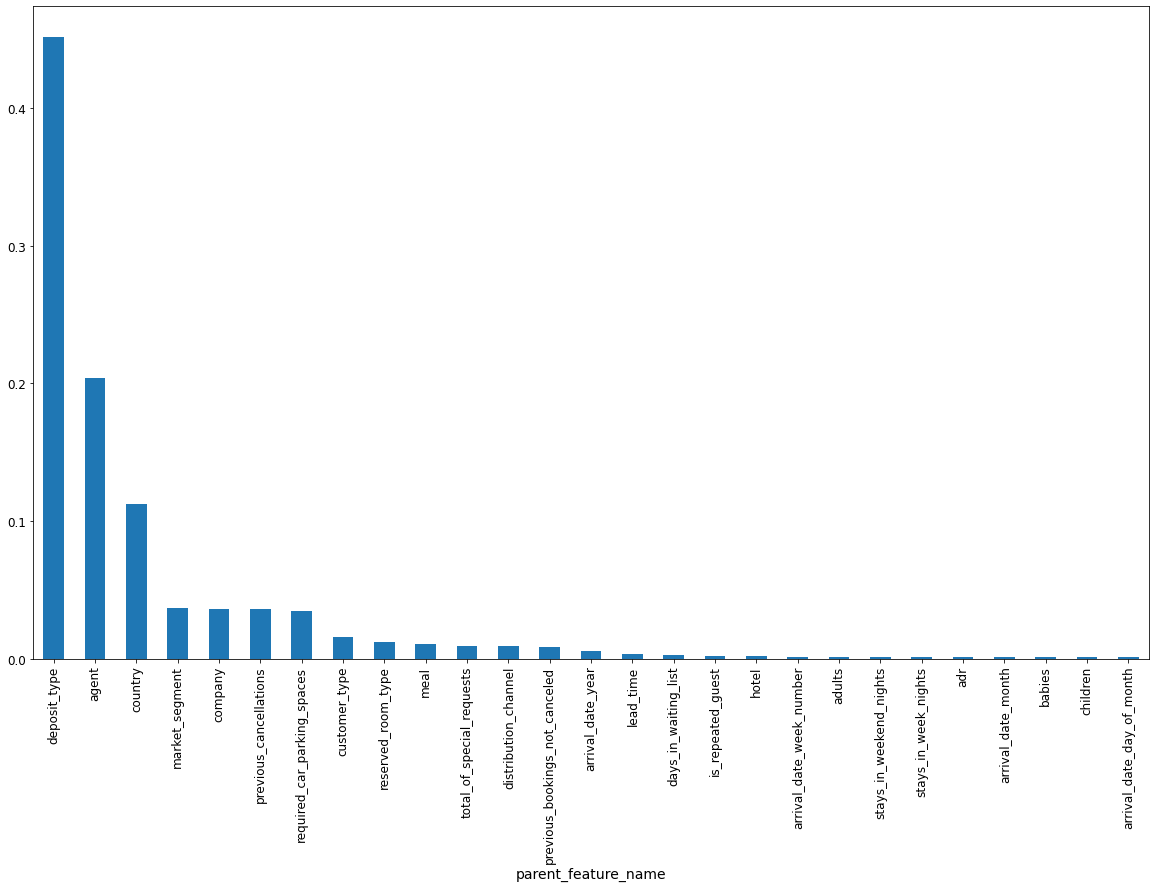

In [157]:
#Feature importance plot
plt.figure(figsize=(20,12))
feature_importances_df.groupby('parent_feature_name')['importance'].sum().sort_values(ascending=False).plot(kind='bar')

### Step 10: Performance on Test Set

In [158]:
yhat_test=xgb_classifier_hotels_tuned.predict(data_test_X) #Predictions on val set
yhat_test[:5]

array([1, 1, 1, 1, 1])

In [159]:
precision_score(data_test_y,yhat_test),recall_score(data_test_y,yhat_test),f1_score(data_test_y,yhat_test)

(0.8375850340136054, 0.7507621951219512, 0.7918006430868166)

That's a pleasent surprise...

<Figure size 864x576 with 0 Axes>

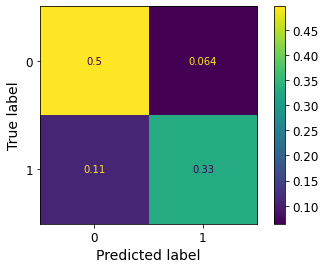

In [160]:
plt.figure(figsize=(12,8))
plot_confusion_matrix(xgb_classifier_hotels_tuned,data_test_X,data_test_y,normalize='all')

In [161]:
df.iloc[23]

hotel                             Resort Hotel
is_canceled                                  0
lead_time                                   72
arrival_date_year                         2015
arrival_date_month                        July
arrival_date_week_number                    27
arrival_date_day_of_month                    1
stays_in_weekend_nights                      2
stays_in_week_nights                         4
adults                                       2
children                                     0
babies                                       0
meal                                        BB
country                                    PRT
market_segment                          Direct
distribution_channel                    Direct
is_repeated_guest                            0
previous_cancellations                       0
previous_bookings_not_canceled               0
reserved_room_type                           D
assigned_room_type                           D
booking_chang

### Step 11: Dummy deployment


- Now that the model is ready and tested, hopefully your model is approved for deployment and production.
- The standard practice is to expose the model via a Web API and then make an API call with the inputs, which is then run through the model and an output is received.
- We will demonstrate that here. We will be taking the help of a service called [ngrok](https://ngrok.com/) to temporarily expose the web app from colab runtime environment to the public web so that we can hit that endpoint.
- We will then try hitting that endpoint from outside and see if we can get the result.
- Note that the model is generally loaded as soon as the webservice starts and then when a request is received, the input is passed through the model and an output is generated.  

**Note: Running the next cell will start the flask server**

In [162]:
#Ideally this piece of code should be present in a seperate file ( say flask.py ) which then should be run.
from flask_ngrok import run_with_ngrok
from flask import Flask,jsonify,make_response,request

#The following few lines will be loaded as soon as the webserver starts
cat_encoder_loaded=load('handson_repo/cat_encoder.pkl')
preprocessing_info_loaded=load('handson_repo/preprocessing_info.pkl')
model_loaded=load('handson_repo/xgb_grid_tuned.pkl')
total_fields_list=preprocessing_info_loaded['cat_cols']+preprocessing_info_loaded['non_cat_cols']

app = Flask(__name__)
run_with_ngrok(app)   #You wont be needing this line when you are going live...This line helps to expose the webapp through ngrok as mentioned above

#The method model_serve() is executed every time a request is sent to the webserver.
@app.route("/",methods=['GET'])
def model_serve():
  fields_missing=[]

  #Checking whether all of the required fields are present
  for each_field in total_fields_list:
    if each_field not in request.args:
      fields_missing.append(each_field)
  
  if len(fields_missing)!=0:
    return make_response(jsonify(message="Bad Request. The following necessary parameters are missing:{}".format(fields_missing),
                                 fields_missing=fields_missing),400) #400 stands for http response code 400 ( Bad Request )

  
  #Preprocess the data

  ##Deal with categorical values
  cat_feats_X=[]
  for each_field in preprocessing_info_loaded['cat_cols']: #Please note that the order of input should be exactly the same as during training
    value=request.args[each_field]
    try:
      value_float=str(float(value))
      value=value_float
    except ValueError:
      pass
    cat_feats_X.append(value)
  cat_feats_enc_X=cat_encoder_loaded.transform([cat_feats_X]) #Note that even though we have 1 request here, we are required to send a 2d array here of shape (1,num_of_cat_cols)
  cat_feats_enc_X=list(cat_feats_enc_X.flatten()) #Converting back from 2d to list....flatten() converts it to 1d
  
  ##Deal with non categorical values
  non_cat_feats_X=[]
  for each_field in preprocessing_info_loaded['non_cat_cols']:
    non_cat_feats_X.append(request.args[each_field])

  ##Take both of them together and send it to the model
  feats_all_X=np.array([cat_feats_enc_X+non_cat_feats_X])
  pred=model_loaded.predict(feats_all_X)[0]
  return make_response(jsonify(message="Model Prediction Successful.",fields_missing=[],prediction=str(pred)),200) #HTTP Code 200 means normal response i.e. everything went correctly.

  
app.run()


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://3142d7bd3904.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


To make an API call to this endpoint using python, here is the sample code:
```
import requests

url = "http://87179bcd1687.ngrok.io/" #This will be different for you

querystring = {"hotel":"Resort%20Hotel","meal":"BB","country":"PRT","market_segment":"Direct","distribution_channel":"Direct","is_repeated_guest":"0","reserved_room_type":"D","deposit_type":"No%20Deposit","agent":"250","company":"NaN","customer_type":"Transient","lead_time":"72","arrival_date_year":"2015","arrival_date_month":"7","arrival_date_week_number":"27","arrival_date_day_of_month":"1","stays_in_weekend_nights":"2","stays_in_week_nights":"4","adults":"2","children":"0","babies":"0","previous_cancellations":"0","previous_bookings_not_canceled":"0","days_in_waiting_list":"0","adr":"99.67","required_car_parking_spaces":"0","total_of_special_requests":"1"}


response = requests.request("GET", url, params=querystring)

print(response.text)
```

# State of the Art Demo

## Using Machine Learning to caption images


- We will be using [Microsoft Cognitive Services API](https://azure.microsoft.com/en-in/services/cognitive-services/computer-vision/) to try and see what output it gives for the following picture.
 > ![Modi Ji Selfie](https://hwnews.in/wp-content/uploads/2020/01/bollywood-960x540.jpg)
- Output:
```
 { "text": "Ranveer Singh, Sidharth Malhotra, Varun Dhawan, Ranbir Kapoor, Narendra Modi, Vicky Kaushal, Rohit Shetty, Ekta Kapoor, Rajkummar Rao, Ayushmann Khurrana posing for the camera", "confidence": 0.9909692 }
```
- Note that the model was able to identify many of the celebrities in the caption itself.



## Using State of The Art NLP Models to Generate Fake Movie Reviews

- NLP ( Natural Language Processing ) is the manipulation of natural text ( i.e. anything to do with unstructured text )
- NLP has gone through a lot of advancements in the last few months thanks to an innovative new architecture called **Transformers**.
- One of the areas where it has exceled is that certain NLP models are able to generate very convincing texts.
- Let's use one such model called **GPT-2** by **OpenAI** to generate a fake review for a fictitious movie.
- https://transformer.huggingface.co/doc/gpt2-large

# What Next?

- The motivation behind the webinar is to try and give a code-first flavour into what Machine Learning is all about.
- It also showed how to approach a typical Machine Learning problem end to end on a real world dataset.
- If you feel inquisitive or want to give Machine Learning a try, here are some good sources to learn more.

Here are few of the courses that you can consider:
- [Machine Learning by Andrew Ng](https://www.coursera.org/learn/machine-learning): Teaches about the fundamentals of Machine Learning
- [Practical Machine Learning for Coders by Jeremy Howard](http://course18.fast.ai/ml):Shows some of the current best practices for Traditional Machine Learning
- [Deeplearning.ai by Andrew Ng](https://www.coursera.org/specializations/deep-learning): Teaches about the fundamentals of Deep Learning
- [Fast.ai by Jeremy Howard](https://course.fast.ai/): Teaches Deep Learning but in a more hands on way
- [Deep Learning Lecture Series by Yann Le Cunn](https://www.youtube.com/playlist?list=PLLHTzKZzVU9eaEyErdV26ikyolxOsz6mq): A very recent lecture series by Yann Le Cunn at NYU where he goes deep into some of the more theoretical aspects of Deep Learning which are generally not covered in other courses. 


# About the Author

- I am a Machine Learning Engineer at a startup working primarily in NLP domain.
- You can find more about me at [rwikdutta.me](https://rwikdutta.me).

# Acknowledgements:

- https://towardsdatascience.com/https-medium-com-faizanahemad-generating-synthetic-classification-data-using-scikit-1590c1632922
- https://github.com/ageron/handson-ml2/
- https://www.kaggle.com/jessemostipak/hotel-booking-demand
- https://www.kaggle.com/marcuswingen/eda-of-bookings-and-ml-to-predict-cancelations
- https://www.kaggle.com/vssseel/eda-various-ml-models-and-nn-with-roc-curves
- https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
- https://medium.com/@kshitijvijay271199/flask-on-google-colab-f6525986797b